In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import math
import numpy as np
import networkx as nx
import random as rn
import scipy
# import igraph
from matplotlib import colors
import scipy.io as sio
import sklearn as skl
from sklearn import covariance
import copy
print 'done'

done


# Data Pipeline for MEG/EEG Functional Brain Networks

The goal of this research thesis is to investigate the changes in functional connectivity networks for patients transitioning between concsious and non-conscious states. Using partial correlation between the time series of EEG and MEG channels, the desire is to apply various graph metrics that quantify network topology and assess whether there is quantifiable differences in anesthesia and resting functional connectivity networks.

The first component of the data pipeline is to read the file into Python from Matlab. The MEG/EEG.fif file is arranged in Matlab is such a way that it saves the data as a large multidimensional array. The data is then saved in Matlab as a .mat file which can then be called into Python. The general outline for the pipeline is as follows:

1: Read in MEG/EEG time series data for resting state and anesthesia. (*Need to investigate auto-correlation and stationarity of the data)

2: For p-channels, segment the time series into bins of N-samples. For full scale head map, N will only be slightly bigger than the number of channels and we will then have p<N. 

3: Assuming that the data is gaussian in nature, that is, it is a multivariate gaussian distribution independent and identically distributed (i.i.d). The underlying distributions is described by $\mathcal{N}(\mu,\Sigma) $, where $\mu$ is the mean vector and $\Sigma$ is the population covariance matrix. Compute the empirical covariance matrix $S$ and inverse covariance matrix $S^{-1}$.

4: From the sample/empirical covariance matrix, estimate the real inverse covariance matrix using sparse inverse covariance estimation. Currently, this is being achieved using GLASSO detailed in the origin paper by "Sparse inverse covariance estimation with the graphical lasso" (Friedman et al., 2007). Furthermore, this is to be partnered with an optimization algorithm that determines the optimal value for $\alpha$ in the GLASSO procedure, which controls the sparsity of the output estimate inverse covariance matrices. Zhu & Cribben 2017, explored various combinations of graphical model estimation algorithms partnered with several selection algorithms, they concluded the most optimal combination was Smoothly Clipped Absolute Deviation (SCAD) and either Bayesian Information Criteria (BIC) or Cross Validation (CV). These combinations outperformed even the GLASSO algorithm at recovering the true off-diagonal elements of the population inverse covariance matrix. Additionally, they explore the issue of autocorrelation and the effects that pre-whitening have on the inferred matrices, concluding that it was best to pre-whiten the data (need to read more "whitening"). Given that, the choice to use GLASSO, may not be ideal, but it is a good place to start, reading is ongoing.

5: Provided with the optimal estimate inverse covariance matrix, use simple algebra to compute the partial correlation matrix.

6: Apply the graph metrics which best characterize the topology of the partial correlation networks; shortest path length, node-degree, node-centrality, clustering coefficient. Taking an average of these metrics to be stored for later steps. 

7: Repeat the below steps 3-6, for I-iterations, and investigate how the graph topology changes over time in both resting state and anesthesia data in effort to quantify any statistically significant differences.

### 1. Read in Data from Matlab and plot single/multi-channel time series

In [2]:
# MEG_DICT = sio.loadmat('ans.mat') # MEG dictionary saved in Matlab - in this case it is closed eye resting state.
# MEG_DATA = MEG_DICT.items() # Accesses the dictionary elements
# single_channel = []
# multi_channel = []

MEG_DICTexr = sio.loadmat('resting_state.mat') # MEG dictionary saved in Matlab - in this case it is closed eye resting state.
MEG_DATAexr = MEG_DICTexr.items() # Accesses the dictionary elements

MEG_DICTex1 = sio.loadmat('xenon_1.mat') # MEG dictionary saved in Matlab - XENON 1.
MEG_DATAex1 = MEG_DICTex1.items() # Accesses the dictionary elements

MEG_DICTex2 = sio.loadmat('xenon_2.mat') # MEG dictionary saved in Matlab - XENON2.
MEG_DATAex2 = MEG_DICTex2.items() # Accesses the dictionary elements

MEG_DICTex3 = sio.loadmat('xenon_3.mat') # MEG dictionary saved in Matlab - XENON3.
MEG_DATAex3 = MEG_DICTex3.items() # Accesses the dictionary elements

MEG_DICTex4 = sio.loadmat('xenon_4.mat') # MEG dictionary saved in Matlab - XENON4.
MEG_DATAex4 = MEG_DICTex4.items() # Accesses the dictionary elements


# The data is read in as a large dictionary of lists. It can be accessed using the appropriate indexes
# Individual channels (sensor - time series) or data points can be accessed with the below indexing calls
# [header][row list][row][entry in row] - must be as shown [1][1][X][Y] 
# 1 is the dictionary key with values that contain all the data.
# 1 is the list of data channels in rows - X is the chosen row and Y is the data point in that row.

# access single channel and all data Y in time series X
# single_channel.extend(MEG_DATA[1][1][0][range(0,1000)])

# # Access multiple channels and select data points in loop
# for i in range(0,10):
#     multi_channel.append(MEG_DATA[1][1][i][range(1,50)])

# # access single channel and all data Y in time series X
# single_channelex1.extend(MEG_DATAex1[1][1][0][range(0,100)])

# # Access multiple channels and select data points in loop
# for i in range(0,10):
#     multi_channelex1.append(MEG_DATAex1[1][1][i][range(0,20)])
    
    
# # access single channel and all data Y in time series X
# single_channelex3.extend(MEG_DATAex3[1][1][0][range(0,100)])

# # Access multiple channels and select data points in loop
# for i in range(0,10):
#     multi_channelex3.append(MEG_DATAex3[1][1][i][range(0,20)])
print 'done'
print len(MEG_DATAexr[1][1][0])

done


### Test of partial correlation estimation pipelines using known network.
Test case with known network structure. We feed in a partial correlation matrix for 5 variables, this provides known covariance and we provide known mean. Using a multivariate gaussian distribution defined by the above mean and covariance, we sample from them and reproduce the graph structure from both the empirical covariance and the estimated covariance obtained using graphical lasso and cross validation.

To test the pipeline, we can feed data from a multivariate gaussian distribution defined by a known mean vector $\mu$ and covariance matrix $\Sigma$. In doing so, we can first construct the estimate covariance matrix using numpy.cov and from that the inverse covariance $\Sigma^{-1}$ and then the partial correlation network. Then running this for multiple iterations, we should observe a stable graph metric (in this case mean EVC) that oscillates a little due to the random sampling of the underlying distribution. As the sample size n, tends to values far greater than the number of random variables (n>>p), the oscillation should settle down and deviate verry little. This is because the input covariance matrix is being well approximated by the sample covariance. Another check is to pre-define a correlation matrix, say for 5 nodes, that are connected in a known way, calculate the covariance matrix from this correlation matrix and then perform the steps to observe if the sample correlation/covariance/partial matrix reproduce the input correlation matrix. This is achieved below and we find, as expected the correlation matrix tends to the input one as sample size increase, and the partial correlation matrix produces edge connections of reduced weight as intended. 

### Permutation Test for Network Statistic
The below plots of mean degree centrality are generated as follows:
1.. Segment 100 sensor time series (100'000 points each) into 2 second intervals (2000 points). This gives a total of 5000 individual times series segments across the 100 sensors.

2.. Take a time segment from each sensor, compute the covariance between the data. Compute the partial correlation networks and for test case, binarize into adjacency network by applying arbritrary threshold (only for testing pipeline case).

3.. Compute the average degree centrality for the network - repeat this 50 times to use all time series segments.

4.. Compute the average mean degree centrality across all 50 networks to get test statistic. 

5.. We wish to know if this value is due to noise or due to actual neural dynamics. To check, we use a permutation test to see if random permutations of the time series segments produces similar results. The thinking is, if it is due to noise, the noise will be present throughout the duration of the MEG recording, thus we should observe similar test statistic.

6.. To permute, we shuffle the 2 second segments for all 100 sensors. In other words, for time series $t_{1} = [x_{1}, x_{2}, x_{3}, \dots ,x_{n}]$ where each $x_{i}$ is made up of 2000 data points, we shuffle the segments randomly $t_{1} = [x_{10}, x_{34}, x_{6}, \dots ,x_{n}]$, and then build up 50 new networks and repeat the above.

7.. This process of shuffling, building 50 new networks, metric application and statistic test attainment, is repeated N number of times. This allows us to produce a distribution of test statistics built from the permutation of the data and enables us to compare our actual test statistic obtained from the ordered time series, with those obtained from permutation. If we observe similar values and there are many like that obtained initially, it would seem that the centrality observed is due to noise and not interesting correlations. However, if we perform the test numerous times and observe the ordered time series value to differ from the others, it is suggestive that the value could be dependent on the underlying activity.

8.. The above is performed and the plots are shown below. As we can see, the random permuted networks fail miserably to reproduce centrality close to that of the ordered network, this seems suggestive that the obtained value is significant. The same is performed for the anesthesia data and the same difference between permuted and ordered is observed.

In [3]:
def f1(x):
    return 1.0/math.sqrt(x)
f1 = np.vectorize(f1)
master_set = copy.deepcopy(MEG_DATAexr[1][1][0:100,0:100000])*1e12
graphs = [[]for i in range(0,300)]
PCN = [[]for i in range(0,300)]

# master_set3 = copy.deepcopy(MEG_DATAex3[1][1][0:100,0:100000])*1e12
# graphs3 = [[]for i in range(0,5000)]
# k_deg = [[] for i in range(0,500)]
# EVC = [[] for i in range(0,500)]
print 'done'

done


In [149]:
known_correlation = np.matrix([[1,0.8,0.75,0.4,0,0,0,0,0,0],[0.8,1,0,0,0,0,0,0,0,0],[0.75,0,1,0,0,0,0,0,0,0],[0.4,0,0,1,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0,0],[0,0,0,0,0,1,0.4,0,0,0.7],[0,0,0,0,0,0.4,1,0,0,0],[0,0,0,0,0,0,0,1,0.95,0],[0,0,0,0,0,0,0.95,0,1,0.5],[0,0,0,0,0,0.7,0,0,0.5,1]])
known_std = [1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5]
dstd = np.diag(known_std)
known_covariance = dstd.dot(known_correlation).dot(dstd)
known_mean = [np.mean(known_covariance[0]), np.mean(known_covariance[1]), np.mean(known_covariance[2]), np.mean(known_covariance[3]), 
np.mean(known_covariance[4]),np.mean(known_covariance[5]), 
np.mean(known_covariance[6]), np.mean(known_covariance[7]), np.mean(known_covariance[8]), 
np.mean(known_covariance[9])]

diag_ = np.diagonal(known_covariance) 
known_inverse = np.diag(f1(diag_))
cross_check_correlation = known_inverse.dot(known_covariance).dot(known_inverse)

TEST = np.random.multivariate_normal(known_mean, known_covariance, 100000).T
EMP_COVARIANCE = np.cov(TEST)

it = 0
# count = 0
# for j in range(0,25):
#     loop_set = TEST[0:10,count:(count+4000)]
#     gl_model = skl.covariance.GraphLassoCV(alphas=10, n_refinements=1, cv=5, assume_centered=False, max_iter=100, tol = 0.001)
#     gl_model.fit(loop_set.T)
#     diag = np.diagonal(gl_model.covariance_)
#     diag_inverse = np.diag(f1(diag))
#     partial_cor = diag_inverse.dot(gl_model.covariance_).dot(1.0*diag_inverse)
#     PCN[it] = partial_cor
#     graphs[it] = nx.Graph(partial_cor)
#     it = it+1
#     count = count+4000
# print 'finished'


for i in range(0,5):
    #if i % 100 == 0:
    print'iteration '+ str(i)
    for j in range(0,25):
        loop_s = [[] for k in range(0,10)]
        for y in range(0,10):    
            z = rn.randint(0,96000)
            loop_s[y] = master_set[y][z:(z+4000)]
        gl_model = skl.covariance.GraphLassoCV(alphas=10, n_refinements=1, cv=5, assume_centered=False, max_iter=100, tol = 0.001)
        gl_model.fit(np.array(loop_s).T)
        diag = np.diagonal(gl_model.covariance_)
        diag_inverse = np.diag(f1(diag))
        partial_cor = diag_inverse.dot(gl_model.covariance_).dot(1.0*diag_inverse)
        PCN[it] = partial_cor
        graphs[it] = nx.Graph(partial_cor)
        it = it+1

print 'finished'

C:\Users\owner\Anaconda\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: covariance is not positive-semidefinite.


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
finished


In [ ]:
def f1(x):
    return 1.0/math.sqrt(x)
f1 = np.vectorize(f1)

In [33]:
it = 0
step = 2000
count = 0
nets = 100000/step
alp = 0.05
cvv = 3
ref = 1
cc = 10
tnet = nets*(1+cc)
master_set = copy.deepcopy(MEG_DATAexr[1][1][0:100,0:100000])*1e12
graphs = [[]for i in range(0,tnet)]
PCN = [[]for i in range(0,tnet)]

print 'fin'

fin


In [34]:
for j in range(0,nets):
    loop_set = master_set[0:100,count:(count+step)]
    gl_model = skl.covariance.GraphLasso(alpha = alp, assume_centered=False, tol = 0.01)
    #gl_model = skl.covariance.GraphLassoCV(alphas=10, n_refinements=ref, cv=cvv, assume_centered=False, max_iter=100, tol = 0.001)
    gl_model.fit(loop_set.T)
    diag = np.diagonal(gl_model.covariance_)
    diag_inverse = np.diag(f1(diag))
    partial_cor = diag_inverse.dot(gl_model.covariance_).dot(1.0*diag_inverse)
    PCN[it] = partial_cor
    graphs[it] = nx.Graph(partial_cor)
    it = it+1
    count = count+step
print 'finished'


for i in range(0,cc):
    #if i % 100 == 0:
    print'iteration '+ str(i)
    for j in range(0,nets):
        loop_s = [[] for k in range(0,100)]
        for y in range(0,100):    
            z = rn.randint(0,(100000-step))
            loop_s[y] = master_set[y][z:(z+step)]
        gl_model = skl.covariance.GraphLasso(alpha = alp, assume_centered=False, tol = 0.01)
        #gl_model = skl.covariance.GraphLassoCV(alphas=10, n_refinements=ref, cv=cvv, assume_centered=False, max_iter=100, tol = 0.001)
        gl_model.fit(np.array(loop_s).T)
        diag = np.diagonal(gl_model.covariance_)
        diag_inverse = np.diag(f1(diag))
        partial_cor = diag_inverse.dot(gl_model.covariance_).dot(1.0*diag_inverse)
        PCN[it] = partial_cor
        graphs[it] = nx.Graph(partial_cor)
        it = it+1
print 'finished'




finished
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
finished


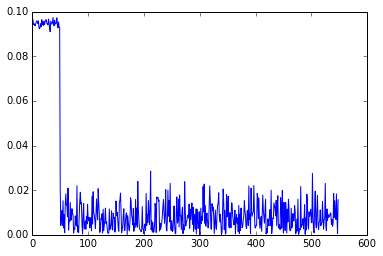

In [60]:
# AVD = []
# for i in range(0,tnet):
#     AVD.append(np.mean(nx.algorithms.assortativity.average_degree_connectivity(graphs[i],weight='weight').values()))
# NAVD = []
# for i in range(0,nets):
#     for j in range(0,1):
#         if AVD[i][j] > 1.0:
#             NAVD.append(AVD[i][j])

# plt.plot(AVD)
# plt.xlim(50,100)


# SUM_PC = []
# for i in range(0,tnet):
#     SUM_PC.append(sum(sum(PCN[i])))
# plt.plot(SUM_PC)
# plt.xlim(50,100)
# EC=[]
# for i in range(0,tnet):
#     if sum(abs(PCN[i][0])) > 1.0:
#         EC.append(nx.algorithms.centrality.eigenvector_centrality(graphs[i],max_iter=1000).values())
# # # print 'finished'
# ECM = []
# for i in range(0,len(EC)):
#     ECM.append(np.mean(EC[i]))
plt.plot(ECM)
# plt.hist(ECM[50:550],bins=50)
# print np.mean(ECM[0:50]) - np.mean(ECM[50:550])
# print np.mean(ECM[50:550])
TEST_MEAN = [np.mean(ECM[0:50]),np.mean(ECM[50:100])]
DIFF = (TEST_MEAN[0] - TEST_MEAN[1])

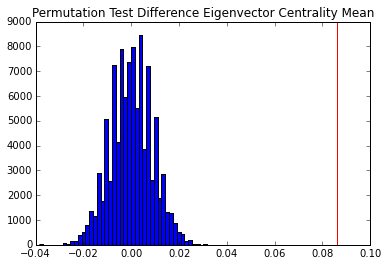

Test Stat 0.0860729577606 number of iterations = 100000
Min from test -0.0382435658883
Max from test 0.0413156037416
Number of values that were greater in magnitude than the test parameter 0
Percentage of values that where greater in magnitude = 0.0%
Results in a p-value of 0.0


In [61]:
D_test = []
ECMM = copy.deepcopy(ECM[0:50])
ECMM.extend(copy.deepcopy(ECM[50:100]))
Iter = 100000

for i in range(0,Iter):
    np.random.shuffle(ECMM)
    TEST_MEAN = [np.mean(ECMM[0:50]),np.mean(ECMM[50:100])]
    D_test.append((TEST_MEAN[0] - TEST_MEAN[1]))

tally = 0
for k in range(0,len(D_test)):
    if abs(D_test[k])>=abs(DIFF):
        tally = tally+1

plt.hist(D_test,bins=50)
plt.axvline(x=DIFF,color='red')
plt.title('Permutation Test Difference Eigenvector Centrality Mean')
plt.show()
print 'Test Stat ' +str(DIFF) + " number of iterations = "+str(Iter)
print "Min from test " +str(min(D_test))
print "Max from test " + str(max(D_test))
print 'Number of values that were greater in magnitude than the test parameter ' +str(tally)
print 'Percentage of values that where greater in magnitude = ' +str(1.0*tally/(1.0*Iter)*100)+"%"
print 'Results in a p-value of ' +str((1.0*tally/(1.0*Iter))) 

### DAMIEN - HERE IS WHAT I REFERRED TO IN THE EMAIL
### Exploration of Eigenvector Centrality of ordered and permuted networks
We can see from the below plots that in the ordered time series, there is a little variability in the EVC for each sensor across multiple time segments (10 - in the plot below). However, when generating the same plots for the permuted data, we see a very obvious profile that does not vary, and it is clearly similar to the ordered case (250 networks sampled). This is suggestive that the glasso is picking out the dominant interactions across sensors and across all times, which would be noise. It seems then currently, that the below suggests the glasso is returning networks built from interactions of noise across sensors which is very possible. More work is to be done to see if this is either a bug or feature. Possible causes: could be issue with EVC calculation, glasso/cv, noise present during recording (would be real signal in that case). Will test the anesthesia data now and if the profile is similiar it would be very suggestive that I am picking out the noise present or the spatial leaking between MEG sensors which is known issue.

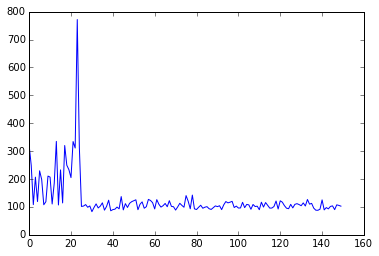

In [163]:

SUM_PC = []
for i in range(0,150):
    SUM_PC.append(sum(sum(PCN[i])))
plt.plot(SUM_PC)

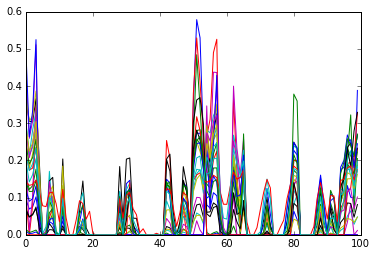

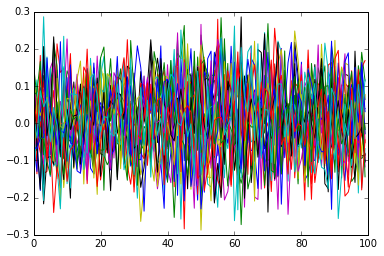

In [164]:
for i in range(0,25):
    plt.plot(EC[i])
plt.show()
for i in range(25,50):
    plt.plot(EC[i])
plt.show()

1.22222222222


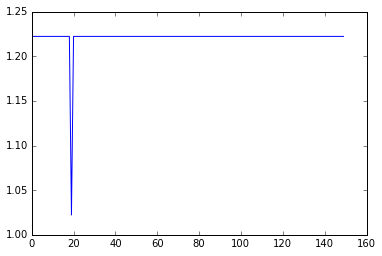

In [146]:
g = 0
mean_centrality=[]
for i in range(0,150):
    mean_centrality.append(np.mean(nx.algorithms.centrality.degree_centrality(graphs[i]).values()))
print mean_centrality[0]
plt.plot(mean_centrality)

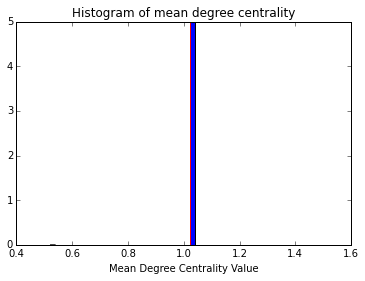

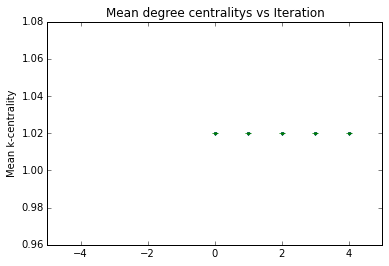

In [168]:
# plt.plot(mean_centrality)
# plt.show()
# plt.plot(mean_centrality)
# plt.xlim(0,100)
# plt.show()
# plt.hist(mean_centrality, bins=100)
# plt.xlim(-0.05,0.05)
# plt.show()

MEAN_CENTRALITY = []
MEAN_DEVIATION = []
count = 0
for i in range(0,5):
    MEAN_CENTRALITY.append(np.mean(mean_centrality[count:count+50]))
    count = count + 50
count = 0
for i in range(0,5):
    MEAN_DEVIATION.append(np.std(mean_centrality[count:count+50]))
    count = count + 50

plt.hist(MEAN_CENTRALITY,bins=50)
plt.title('Histogram of mean degree centrality')
plt.xlabel('Mean Degree Centrality Value')
plt.axvline(x=MEAN_CENTRALITY[0],color='red')
plt.show()

x = np.arange(0,len(MEAN_CENTRALITY))
plt.plot(MEAN_CENTRALITY,'.')
plt.title('Mean degree centralitys vs Iteration')
plt.ylabel('Mean k-centrality')
plt.errorbar(x, MEAN_CENTRALITY,MEAN_DEVIATION, linestyle='None', marker='.')
plt.xlim(-5,5)
plt.show()

### Analysing the difference between resting state and anesthesia

In [31]:
print len(MEG_DATAex1[4][1])
print 
#print MEG_DATAexr[1][1]

102



In [231]:
def f1(x):
    return 1.0/math.sqrt(x)
f1 = np.vectorize(f1)

master_set = (MEG_DATAexr[1][1][0:100,0:100000])*1e12
master_set1 = (MEG_DATAex1[4][1][0:100,0:100000])*1e12
master_set2 = (MEG_DATAex2[1][1][0:100,0:100000])*1e12
master_set3 = (MEG_DATAex3[1][1][0:100,0:100000])*1e12
master_set4 = (MEG_DATAex4[1][1][0:100,0:100000])*1e12

graphs = [[]for i in range(0,250)]
PCN = [[]for i in range(0,250)]
alphas = [[]for i in range(0,250)]

print 'fin'

fin


In [232]:
it = 0
step = 5000
count = 0
nets = 100000/step
alp = 0.3
cvv = 10
ref = 1
#gl_model = skl.covariance.GraphLasso(alpha = alp,tol = 0.001,assume_centered=False)

for j in range(0,nets):
    loop_set = master_set[0:100,count:(count+step)]
    gl_model = skl.covariance.GraphLassoCV(alphas=10, n_refinements=ref, cv=cvv, assume_centered=False, max_iter=100, tol = 0.001)
    #gl_model = skl.covariance.GraphLasso(alpha = alp,tol = 0.001,assume_centered=False)
    gl_model.fit(loop_set.T)
    #alphas[it] = gl_model.alpha_
    diag = np.diagonal(gl_model.covariance_)
    diag_inverse = np.diag(f1(diag))
    partial_cor = diag_inverse.dot(gl_model.covariance_).dot(1.0*diag_inverse)
    PCN[it] = partial_cor
    #graphs[it] = nx.Graph(partial_cor)
    it = it+1
    count = count+step
print 'finished'

count = 0
for j in range(0,nets):
    loop_set1 = master_set1[0:100,count:(count+step)]
    gl_model = skl.covariance.GraphLassoCV(alphas=10, n_refinements=ref, cv=cvv, assume_centered=False, max_iter=100, tol = 0.001)
    #gl_model = skl.covariance.GraphLasso(alpha = alp,tol = 0.001,assume_centered=False)
    gl_model.fit(loop_set1.T)
    #alphas[it] = gl_model.alpha_
    diag = np.diagonal(gl_model.covariance_)
    diag_inverse = np.diag(f1(diag))
    partial_cor = diag_inverse.dot(gl_model.covariance_).dot(1.0*diag_inverse)
    PCN[it] = partial_cor
    #graphs[it] = nx.Graph(partial_cor)
    it = it+1
    count = count+step
print 'finished'

count = 0
for j in range(0,nets):
    loop_set2 = master_set2[0:100,count:(count+step)]
    gl_model = skl.covariance.GraphLassoCV(alphas=10, n_refinements=ref, cv=cvv, assume_centered=False, max_iter=100, tol = 0.001)
    #gl_model = skl.covariance.GraphLasso(alpha = alp,tol = 0.001,assume_centered=False)
    gl_model.fit(loop_set2.T)
    #alphas[it] = gl_model.alpha_
    diag = np.diagonal(gl_model.covariance_)
    diag_inverse = np.diag(f1(diag))
    partial_cor = diag_inverse.dot(gl_model.covariance_).dot(1.0*diag_inverse)
    PCN[it] = partial_cor
    #graphs[it] = nx.Graph(partial_cor)
    it = it+1
    count = count+step
print 'finished'

count = 0
for j in range(0,nets):
    loop_set3 = master_set3[0:100,count:(count+step)]
    gl_model = skl.covariance.GraphLassoCV(alphas=10, n_refinements=ref, cv=cvv, assume_centered=False, max_iter=100, tol = 0.001)
    #gl_model = skl.covariance.GraphLasso(alpha = alp,tol = 0.001,assume_centered=False)
    gl_model.fit(loop_set3.T)
    #alphas[it] = gl_model.alpha_
    diag = np.diagonal(gl_model.covariance_)
    diag_inverse = np.diag(f1(diag))
    partial_cor = diag_inverse.dot(gl_model.covariance_).dot(1.0*diag_inverse)
    PCN[it] = partial_cor
    #graphs[it] = nx.Graph(partial_cor)
    it = it+1
    count = count+step
print 'finished'

count = 0
for j in range(0,nets):
    loop_set4 = master_set4[0:100,count:(count+step)]
    gl_model = skl.covariance.GraphLassoCV(alphas=10, n_refinements=ref, cv=cvv, assume_centered=False, max_iter=100, tol = 0.001)
    #gl_model = skl.covariance.GraphLasso(alpha = alp,tol = 0.001,assume_centered=False)
    gl_model.fit(loop_set4.T)
    alphas[it] = gl_model.alpha_
    diag = np.diagonal(gl_model.covariance_)
    diag_inverse = np.diag(f1(diag))
    partial_cor = diag_inverse.dot(gl_model.covariance_).dot(1.0*diag_inverse)
    PCN[it] = partial_cor
    #graphs[it] = nx.Graph(partial_cor)
    it = it+1
    count = count+step
print 'finished'

tnet = nets*5


#     loop_set = skl.preprocessing.scale(loop_set)
#     oas_ = skl.covariance.oas(loop_set.T,assume_centered=True)
#     oas_cov = oas_[0]

finished
finished
finished
finished
finished


C:\Users\owner\Anaconda\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in reciprocal


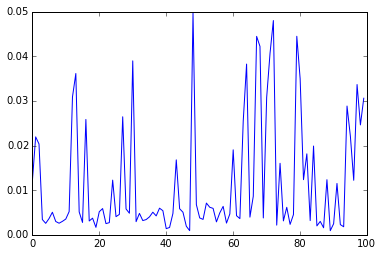

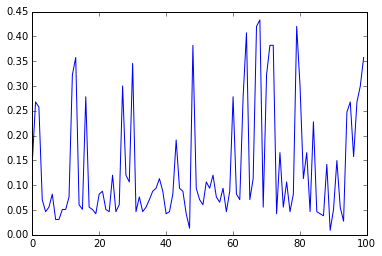

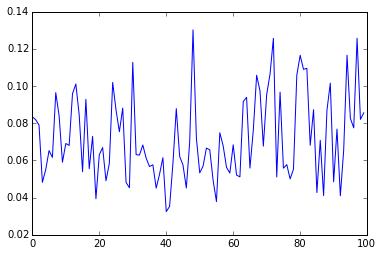

In [233]:
ZPCN = copy.deepcopy(PCN)

g_ef = []
g_efw = []

pinf = float('+inf')

for i in range(0,tnet):
    TES = (abs(ZPCN[i]))
    TES[abs(TES)==0] = 0
    ZY = np.reciprocal(TES)
    ZY[ZY == pinf] = 0
    np.fill_diagonal(ZY,0)
    XYZ = nx.Graph(ZY)
    g_efw.append(global_efficiency(XYZ,weight='weight'))
    g_ef.append(global_efficiency(XYZ))


e_g = []
for i in range(0,tnet):
    if g_ef[i] !=0:
        e_g.append(g_efw[i]/g_ef[i])

plt.plot(g_efw)
plt.show()
plt.plot(g_ef)
plt.show()
plt.plot(e_g)


20


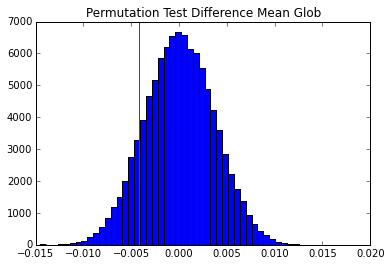

Test Stat -0.00415373864171 number of iterations = 100000
Min from test -0.0144978932428
Max from test 0.0161744596252
Number of values that were greater in magnitude than the test parameter 25557
Percentage of values that where greater in magnitude = 25.557%
Results in a p-value of 0.25557


In [234]:
#TEST_MEAN_GER = [np.mean(e_g[0:50]),np.mean(e_g[50:100]),np.mean(e_g[100:150]),np.mean(e_g[150:200]),np.mean(e_g[200:250])]
jkl = nets
print jkl
#TEST_MEAN_GER = [np.mean(e_g[0:jkl]),np.mean(e_g[jkl:jkl*2]),np.mean(e_g[jkl*2:jkl*3]),np.mean(e_g[jkl*3:jkl*4]),np.mean(e_g[jkl*4:jkl*5])]
TEST_MEAN_GER = [np.mean(g_efw[0:jkl]),np.mean(g_efw[jkl:jkl*2]),np.mean(g_efw[jkl*2:jkl*3]),np.mean(g_efw[jkl*3:jkl*4]),np.mean(g_efw[jkl*4:jkl*5])]
#TEST_MEAN_GER = [np.mean(g_efw[0:50]),np.mean(g_efw[50:100]),np.mean(g_efw[100:150]),np.mean(g_efw[150:200]),np.mean(g_efw[200:250])]
#TEST_MEAN_GER = [np.mean(g_efw[0:20]),np.mean(g_efw[20:40]),np.mean(g_efw[40:60]),np.mean(g_efw[60:80]),np.mean(g_efw[80:100])]
DIFF_GER = (TEST_MEAN_GER[0] - TEST_MEAN_GER[4])

D_test_GER = []
MEAN_GER = copy.deepcopy(g_efw[0:20])
MEAN_GER.extend(copy.deepcopy(g_efw[80:100]))
#MEAN_GER = copy.deepcopy(g_efw[0:20])
#MEAN_GER.extend(copy.deepcopy(g_efw[80:100]))
Iter = 100000


for i in range(0,Iter):
    np.random.shuffle(MEAN_GER)
    TEST_MEAN_GER = [np.mean(MEAN_GER[0:nets]),np.mean(MEAN_GER[nets:nets*2])]
    D_test_GER.append((TEST_MEAN_GER[0] - TEST_MEAN_GER[1]))

tally = 0
for k in range(0,len(D_test_GER)):
    if abs(D_test_GER[k])>=abs(DIFF_GER):
        tally = tally+1

plt.hist(D_test_GER,bins=50)
plt.axvline(x=DIFF_GER,color='red')
plt.title('Permutation Test Difference Mean Glob')
plt.show()
print 'Test Stat ' +str(DIFF_GER) + " number of iterations = "+str(Iter)
print "Min from test " +str(min(D_test_GER))
print "Max from test " + str(max(D_test_GER))
print 'Number of values that were greater in magnitude than the test parameter ' +str(tally)
print 'Percentage of values that where greater in magnitude = ' +str(1.0*tally/(1.0*Iter)*100)+"%"
print 'Results in a p-value of ' +str((1.0*tally/(1.0*Iter))) 

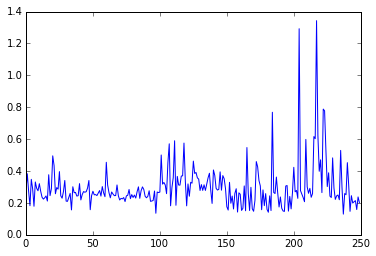

mean alpha across iterations 0.297441728316
std in alpha across iterations 0.1418263724
max alpha across iterations 1.3431636169
min alpha across iterations 0.129660273361


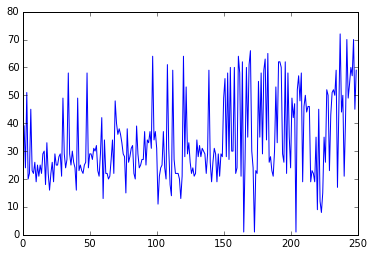

In [81]:
# print [np.mean(alphas[0:20]),np.mean(alphas[20:40]),np.mean(alphas[40:60]),np.mean(alphas[60:80]),np.mean(alphas[80:100])]
# print [np.mean(alphas[0:50]),np.mean(alphas[50:100]),np.mean(alphas[100:150]),np.mean(alphas[150:200]),np.mean(alphas[200:250])]

plt.plot(alphas[0:tnet])
plt.show()


print 'mean alpha across iterations ' +str((np.mean(alphas[0:tnet])))
print 'std in alpha across iterations ' +str(np.std(alphas[0:tnet]))
print 'max alpha across iterations ' +str(max(alphas[0:tnet]))
print 'min alpha across iterations ' +str(min(alphas[0:tnet]))

edge_tally = []
for j in range(0,tnet):
    tow = 0
    for i in range(0,100):
        if PCN[j][0][i] > 0.:
            tow = tow+1
    edge_tally.append(tow)
plt.plot(edge_tally)
# print PCN[220][0]

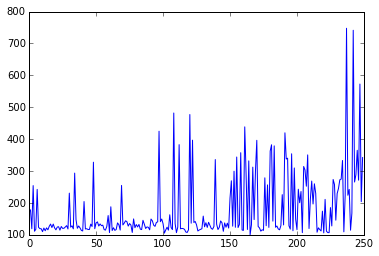

In [82]:
SUM_PC = []
for i in range(0,tnet):
    SUM_PC.append(np.mean(sum(sum(PCN[i]))))
plt.plot(SUM_PC)

# print sum(sum(sum(PCN[0:50])))
# print sum(sum(sum(PCN[50:100])))

20


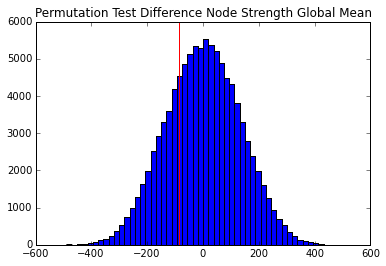

Test Stat -84.2714176195 number of iterations = 100000
Min from test -488.144055015
Max from test 451.314337769
Number of values that were greater in magnitude than the test parameter 53944
Percentage of values that where greater in magnitude = 53.944%
Results in a p-value of 0.53944


In [111]:
TEST_MEAN_S = [np.mean(SUM_PC[0:10]),np.mean(SUM_PC[10:20]),np.mean(SUM_PC[20:30]),np.mean(SUM_PC[30:40]),np.mean(SUM_PC[40:50])]
# TEST_MEAN_S = [np.mean(SUM_PC[0:20]),np.mean(SUM_PC[20:40]),np.mean(SUM_PC[40:60]),np.mean(SUM_PC[60:80]),np.mean(SUM_PC[80:100])]
# TEST_MEAN_S = [np.mean(SUM_PC[0:50]),np.mean(SUM_PC[50:100]),np.mean(SUM_PC[100:150]),np.mean(SUM_PC[150:200]),np.mean(SUM_PC[200:250])]
DIFF_S = (TEST_MEAN_S[0] - TEST_MEAN_S[4])

D_test_S = []
MEAN_STRENGTH = copy.deepcopy(SUM_PC[0:10])
MEAN_STRENGTH.extend(copy.deepcopy(SUM_PC[40:50]))
print len(MEAN_STRENGTH)
Iter = 100000


for i in range(0,Iter):
    np.random.shuffle(MEAN_STRENGTH)
    TEST_MEAN_S = [np.mean(MEAN_STRENGTH[0:10]),np.mean(MEAN_STRENGTH[10:20])]
    D_test_S.append((TEST_MEAN_S[0] - TEST_MEAN_S[1]))

tally = 0
for k in range(0,len(D_test_S)):
    if abs(D_test_S[k])>=abs(DIFF_S):
        tally = tally+1

plt.hist(D_test_S,bins=50)
plt.axvline(x=DIFF_S,color='red')
plt.title('Permutation Test Difference Node Strength Global Mean')
plt.show()
print 'Test Stat ' +str(DIFF_S) + " number of iterations = "+str(Iter)
print "Min from test " +str(min(D_test_S))
print "Max from test " + str(max(D_test_S))
print 'Number of values that were greater in magnitude than the test parameter ' +str(tally)
print 'Percentage of values that where greater in magnitude = ' +str(1.0*tally/(1.0*Iter)*100)+"%"
print 'Results in a p-value of ' +str((1.0*tally/(1.0*Iter))) 

In [83]:
EC=[]
for i in range(0,tnet):
    EC.append(nx.algorithms.centrality.eigenvector_centrality(graphs[i], weight='weight',max_iter=1000).values())
print 'finished'

finished


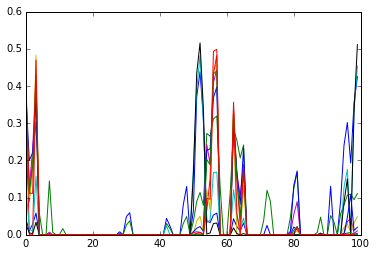

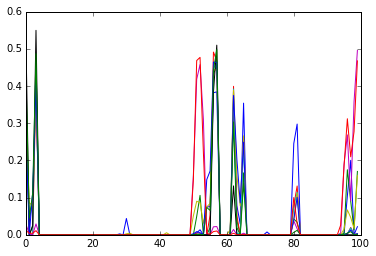

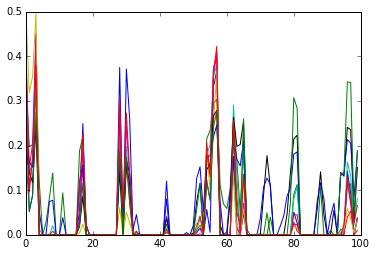

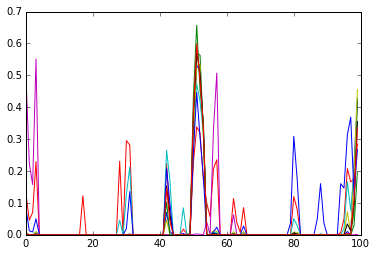

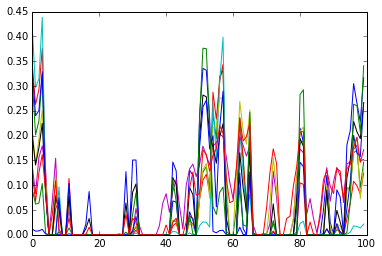

In [19]:
for i in range(0,10):
    plt.plot(EC[i])
plt.show()
for i in range(50,60):
    plt.plot(EC[i])
plt.show()
for i in range(100,110):
    plt.plot(EC[i])
plt.show()
for i in range(150,160):
    plt.plot(EC[i])
plt.show()
for j in range(200,210):
    plt.plot(EC[j])
plt.show()

[0.037299091654802094, 0.037456289851862647, 0.038006359909914952, 0.038793332259647706, 0.040898699340787832]


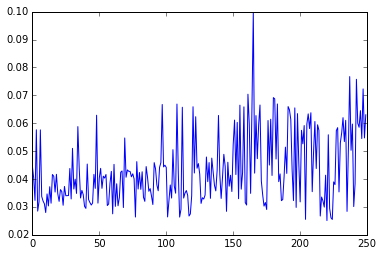

In [84]:
ECM = [np.mean(EC[j]) for j in range(0,tnet)]
plt.plot(ECM)

# TEST_MEAN = [np.mean(ECM[0:20]),np.mean(ECM[20:40]),np.mean(ECM[40:60]),np.mean(ECM[60:80]),np.mean(ECM[80:100])]
# TEST_MEAN = [np.mean(ECM[0:50]),np.mean(ECM[50:100]),np.mean(ECM[100:150]),np.mean(ECM[150:200]),np.mean(ECM[200:250])]
# print TEST_MEAN
# print
# DIFF = (TEST_MEAN[0] - TEST_MEAN[1])
# print DIFF
# print (TEST_MEAN[0] - TEST_MEAN[2])
# print (TEST_MEAN[0] - TEST_MEAN[3])
# print (TEST_MEAN[0] - TEST_MEAN[4])
print [np.mean(ECM[0:20]),np.mean(ECM[20:40]),np.mean(ECM[40:60]),np.mean(ECM[60:80]),np.mean(ECM[80:100])]

100


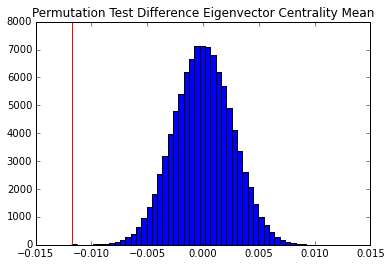

Test Stat -0.0117248411496 number of iterations = 100000
Min from test -0.0117325091533
Max from test 0.0121174846731
Number of values that were greater in magnitude than the test parameter 2
Percentage of values that where greater in magnitude = 0.002%
Results in a p-value of 2e-05


In [85]:
# TEST_MEAN = [np.mean(ECM[0:20]),np.mean(ECM[20:40]),np.mean(ECM[40:60]),np.mean(ECM[60:80]),np.mean(ECM[80:100])]
# TEST_MEAN = [np.mean(ECM[0:10]),np.mean(ECM[10:20]),np.mean(ECM[20:30]),np.mean(ECM[30:40]),np.mean(ECM[40:50])]
TEST_MEAN = [np.mean(ECM[0:50]),np.mean(ECM[50:100]),np.mean(ECM[100:150]),np.mean(ECM[150:200]),np.mean(ECM[200:250])]
DIFF = (TEST_MEAN[0] - TEST_MEAN[4])

D_test = []
ECMM = copy.deepcopy(ECM[0:50])
ECMM.extend(copy.deepcopy(ECM[200:250]))
print len(ECMM)
Iter = 100000


for i in range(0,Iter):
    np.random.shuffle(ECMM)
    TEST_MEAN = [np.mean(ECMM[0:50]),np.mean(ECMM[50:100])]
    D_test.append((TEST_MEAN[0] - TEST_MEAN[1]))

tally = 0
for k in range(0,len(D_test)):
    if abs(D_test[k])>=abs(DIFF):
        tally = tally+1

plt.hist(D_test,bins=50)
plt.axvline(x=DIFF,color='red')
plt.title('Permutation Test Difference Eigenvector Centrality Mean')
plt.show()
print 'Test Stat ' +str(DIFF) + " number of iterations = "+str(Iter)
print "Min from test " +str(min(D_test))
print "Max from test " + str(max(D_test))
print 'Number of values that were greater in magnitude than the test parameter ' +str(tally)
print 'Percentage of values that where greater in magnitude = ' +str(1.0*tally/(1.0*Iter)*100)+"%"
print 'Results in a p-value of ' +str((1.0*tally/(1.0*Iter))) 

In [117]:
def global_efficiency(G, weight=None):
    N = len(G)
    if N < 2:
        return 0   
    inv_lengths = []
    for node in G:
        if weight is None:
            lengths = nx.single_source_shortest_path_length(G, node)
        else:
            lengths=nx.single_source_dijkstra_path_length(G,node,weight=weight)

        inv = [1/x for x in lengths.values() if x is not 0]
        inv_sum = sum(inv)
        inv_lengths.append(inv_sum)  # add results, one per node

    return sum(inv_lengths)/(N*(1.0*N-1))

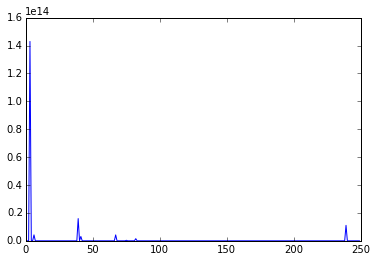

733937463592.0
9.10157327388e+12
1.42897996387e+14
0


In [100]:
# full_m = np.ones((100,100))
# full_m = full_m*0.5
# full_g = nx.Graph(full_m)
# print full_g.degree()
# print global_efficiency(full_g,weight='weight')
# glob_ef = []
# for i in range(0,tnet):
#     glob_ef.append(global_efficiency(pos_graphs[i],weight='weight'))
plt.plot(glob_ef)
plt.show()

print np.mean(glob_ef)
print np.std(glob_ef)
print max(glob_ef)
print min(glob_ef)
# print global_efficiency(pos_graphs[0],weight='weight')
# plt.plot(graphs[0].degree(weight='weight').values())


In [86]:
pos_graphs = []
for i in range(0,tnet):
    pos_graphs.append(abs(PCN[i]))
print 'fin'
pos_graphs = [nx.Graph(pos_graphs[x]) for x in range(0,tnet)]

fin


In [88]:
# print nx.algorithms.clustering(graphs[30], weight='weight').values()
PC_cluster = []
for i in range(0,tnet):
    PC_cluster.append(nx.algorithms.clustering(pos_graphs[i], weight='weight').values())
print 'finished'

finished


250
[0.0065089220426613617, 0.0066484151649678358]

-0.000139493122306


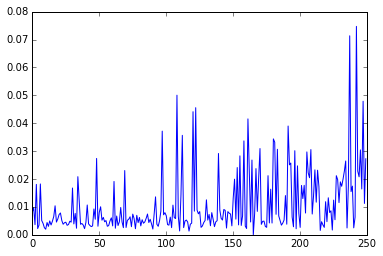

In [89]:
print len(PC_cluster)
clust_mean = [np.mean(PC_cluster[j]) for j in range(0,250)]

plt.plot(clust_mean)

CLUST_TEST_MEAN = [np.mean(clust_mean[0:50]),np.mean(clust_mean[50:100])]
print CLUST_TEST_MEAN
print
CLUST_DIFF = (CLUST_TEST_MEAN[0] - CLUST_TEST_MEAN[1])
print CLUST_DIFF

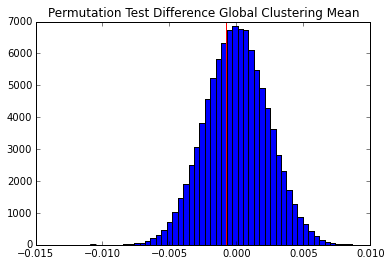

Test Stat -0.000747463191607 number of iterations = 100000
Min from test -0.0108877365728
Max from test 0.00943049512458
Number of values that were greater in magnitude than the test parameter 75026
Percentage of values that where greater in magnitude = 75.026%
Results in a p-value of 0.75026


In [92]:
D2_test = []
clust_mean_C = copy.deepcopy(clust_mean[0:250])
Iter = 100000

for i in range(0,Iter):
    np.random.shuffle(clust_mean_C)
    CLUST_TEST_MEAN = [np.mean(clust_mean_C[0:50]),np.mean(clust_mean_C[50:100])]
    D2_test.append((CLUST_TEST_MEAN[0] - CLUST_TEST_MEAN[1]))

tally = 0
for k in range(0,len(D2_test)):
    if abs(D2_test[k])>=abs(CLUST_DIFF):
        tally = tally+1

plt.hist(D2_test,bins=50)
plt.axvline(x=CLUST_DIFF,color='red')
plt.title('Permutation Test Difference Global Clustering Mean')
plt.show()
print 'Test Stat ' +str(CLUST_DIFF) + " number of iterations = "+str(Iter)
print "Min from test " +str(min(D2_test))
print "Max from test " + str(max(D2_test))
print 'Number of values that were greater in magnitude than the test parameter ' +str(tally)
print 'Percentage of values that where greater in magnitude = ' +str(1.0*tally/(1.0*Iter)*100)+"%"
print 'Results in a p-value of ' +str((1.0*tally/(1.0*Iter))) 

In [90]:
PC_path = []
for i in range(0,250):
    PC_path.append(nx.algorithms.shortest_paths.all_pairs_dijkstra_path_length(pos_graphs[i],weight='weight').values())

print 'fin'

fin


6.34123529716e-07
[0.00010078734113858477, 5.6392289098375168e-05, 0.00039526311085794601, 0.0003487287912598231, 0.00072249538468055767]

4.43950520402e-05
[2.7216143706756548e-07, 1.0943185303831455e-05, 6.5562318080661602e-05, 2.1763212288986453e-14, 9.6626145434689661e-06, 0.0001199894739421087, 1.3640543507157252e-13, 1.3794113441913107e-05, 9.5114789113287146e-06, 1.5440057265186552e-06, 1.1004220976670273e-06, 1.5678127130937159e-07, 1.0945794349664335e-05, 0.00015609777655688068, 5.8849253615755877e-05, 2.0226992073222862e-06, 4.3662566605067433e-06, 0.0015983248663868342, 1.4426711859779618e-05, 1.2445026809403717e-08, 0.00021390969184786963, 0.000309291893994288, 3.6464620933503598e-05, 4.3486072385118797e-05, 1.8245311698968555e-07, 2.7901087191155225e-05, 5.8145477166248015e-05, 8.399800868801449e-09, 4.9527689065068244e-05, 3.0549932039819315e-05, 0.0003668943372332056, 2.6187800748617409e-05, 3.8310684646640539e-05, 2.1252353572218938e-11, 0.000261964195383521, 0.00028547

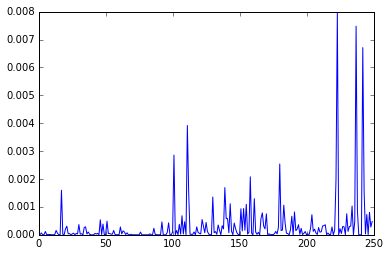

In [92]:
print np.mean(PC_path[0][0].values())
mean_path = [[]for x in range(0,250)]
for i in range(0,250):
    for j in range(0,31):
        mean_path[i].append(np.mean(PC_path[i][j].values()))

global_mean_path = []
for i in range(0,250):
    global_mean_path.append(np.mean(mean_path[i]))
plt.plot(global_mean_path)
# plt.xlim(0,60)
# plt.ylim(0,0.001)

PATH_TEST_MEAN = [np.mean(global_mean_path[0:50]),np.mean(global_mean_path[50:100]),np.mean(global_mean_path[100:150]), np.mean(global_mean_path[150:200]),np.mean(global_mean_path[200:250])]
print PATH_TEST_MEAN
print
PATH_DIFF = (PATH_TEST_MEAN[0] - PATH_TEST_MEAN[1])
print PATH_DIFF
# print global_mean_path
print global_mean_path

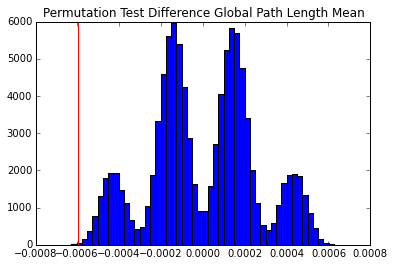

Test Stat -0.000599024804839 number of iterations = 100000
Min from test -0.000628874450542
Max from test 0.000626211738276
Number of values that were greater in magnitude than the test parameter 29
Percentage of values that where greater in magnitude = 0.029%
Results in a p-value of 0.00029


In [154]:
PATH_DIFF = (PATH_TEST_MEAN[0] - PATH_TEST_MEAN[4])
D3_test = []
global_mean_path_C = copy.deepcopy(global_mean_path[0:50])
global_mean_path_C.extend(copy.deepcopy(global_mean_path[200:250]))
Iter = 100000

for i in range(0,Iter):
    np.random.shuffle(global_mean_path_C)
    PATH_TEST_MEAN = [np.mean(global_mean_path_C[0:50]),np.mean(global_mean_path_C[50:100])]
    D3_test.append((PATH_TEST_MEAN[0] - PATH_TEST_MEAN[1]))

tally = 0
for k in range(0,len(D3_test)):
    if abs(D3_test[k])>=abs(PATH_DIFF):
        tally = tally+1

plt.hist(D3_test,bins=50)
plt.axvline(x=PATH_DIFF,color='red')
plt.title('Permutation Test Difference Global Path Length Mean')
plt.show()
print 'Test Stat ' +str(PATH_DIFF) + " number of iterations = "+str(Iter)
print "Min from test " +str(min(D3_test))
print "Max from test " + str(max(D3_test))
print 'Number of values that were greater in magnitude than the test parameter ' +str(tally)
print 'Percentage of values that where greater in magnitude = ' +str(1.0*tally/(1.0*Iter)*100)+"%"
print 'Results in a p-value of ' +str((1.0*tally/(1.0*Iter)))

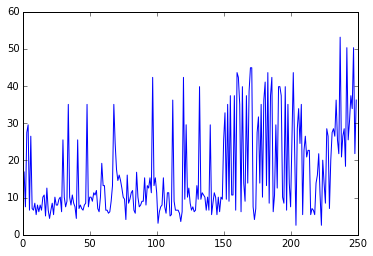

In [161]:
PC_degree = []
for i in range(0,250):
    PC_degree.append(nx.degree(graphs[i]).values())

for i in range(0,250):
    PC_degree[i] = np.mean(PC_degree[i])
plt.plot(PC_degree)


[2.4023417664309132, 2.4434751957486007, 2.4883590920251732, 3.2550217939558799, 3.5035491739669937]



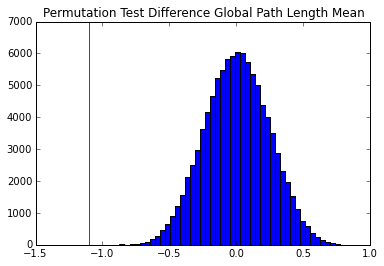

Test Stat -1.10120740754 number of iterations = 100000
Min from test -0.871332831527
Max from test 0.994756822514
Number of values that were greater in magnitude than the test parameter 0
Percentage of values that where greater in magnitude = 0.0%
Results in a p-value of 0.0


In [111]:
DEGREE_TEST_MEAN = [np.mean(PC_degree[0:50]),np.mean(PC_degree[50:100]),
                  np.mean(PC_degree[100:150]), np.mean(PC_degree[150:200]),np.mean(PC_degree[200:250])]

print DEGREE_TEST_MEAN
print
DEGREE_DIFF = (DEGREE_TEST_MEAN[0] - DEGREE_TEST_MEAN[4])

D5_test = []
PC_degree_C = copy.deepcopy(PC_degree[0:50])
PC_degree_C.extend(copy.deepcopy(PC_degree[200:250]))
Iter = 100000

for i in range(0,Iter):
    np.random.shuffle(PC_degree_C)
    DEGREE_TEST_MEAN = [np.mean(PC_degree_C[0:50]),np.mean(PC_degree_C[50:100])]
    D5_test.append((DEGREE_TEST_MEAN[0] - DEGREE_TEST_MEAN[1]))

tally = 0
for k in range(0,len(D5_test)):
    if abs(D5_test[k])>=abs(DEGREE_DIFF):
        tally = tally+1

plt.hist(D5_test,bins=50)
plt.axvline(x=DEGREE_DIFF,color='red')
plt.title('Permutation Test Difference Global Path Length Mean')
plt.show()
print 'Test Stat ' +str(DEGREE_DIFF) + " number of iterations = "+str(Iter)
print "Min from test " +str(min(D5_test))
print "Max from test " + str(max(D5_test))
print 'Number of values that were greater in magnitude than the test parameter ' +str(tally)
print 'Percentage of values that where greater in magnitude = ' +str(1.0*tally/(1.0*Iter)*100)+"%"
print 'Results in a p-value of ' +str((1.0*tally/(1.0*Iter)))

In [357]:
# reduced_networks = copy.deepcopy(PCN[0:100][0:100])
# print (reduced_networks[0][5])

# checks = [[[] for x in range(0,100)]for y in range(0,100)]
# for i in range(0,100):
#     for j in range(0,100):
#         for k in range(0,100):
#             if reduced_networks[i][j][k] > 0. and sum(reduced_networks[i][j]) >1.0:
#                 checks[i][j].append(reduced_networks[i][j][k])
# #             else:
# #                 checks[i][j].append(-20.)
# print checks[0][0]

In [44]:
def f1(x):
    return 1.0/math.sqrt(x)
f1 = np.vectorize(f1)
#---Network of 5 nodes defined by the below correlation matrix---#

known_correlation = np.matrix([[1,0,0,0.8,0],[0,1,0,0.1,0],[0,0,1,0.5,0],[0.8,0.1,0.5,1,0],[0,0,0,0,1]])
known_std = [1.5,1.5,1.5,1.5,1.5]
dstd = np.diag(known_std)
known_covariance = dstd.dot(known_correlation).dot(dstd)
known_mean = [np.mean(known_covariance[0]), np.mean(known_covariance[1]), np.mean(known_covariance[2]), np.mean(known_covariance[3]), np.mean(known_covariance[4])]
diag_ = np.diagonal(known_covariance) 
known_inverse = np.diag(f1(diag_))
cross_check_correlation = known_inverse.dot(known_covariance).dot(known_inverse)
print known_covariance
print
# print known_covariance
# print

#---Multivariate Gaussian defined by above mean and covariance---#
# In the limit that N--->infinity, the Empirical covariance = true covariance.
# pcn should tend to known_correlation as N is increased, this is observed below.
TEST = np.random.multivariate_normal(known_mean, known_covariance, 10).T
EMP_COVARIANCE = np.cov(TEST)
diag_e = np.diagonal(EMP_COVARIANCE) 
ic = np.diag(f1(diag_e))
pcn = ic.dot(EMP_COVARIANCE).dot(1.0*ic)
print EMP_COVARIANCE
print

#---Test of glasso and cross validation with known data---#
TEST = skl.preprocessing.scale(TEST)
TEST = TEST.T
test_model = skl.covariance.GraphLassoCV(alphas=10, n_refinements=2, cv=3, assume_centered=False, max_iter=300,  mode='lars', tol = 0.00000001)
test_model.fit(TEST)

test_cov = test_model.covariance_
test_prec = test_model.precision_
t_diag = np.diagonal(test_cov) 
test_IC = np.diag(f1(t_diag))
test_PC = test_IC.dot(test_cov).dot(1.0*test_IC)
print test_cov
print
# print test_model.alpha_
# ALPHA = test_model.alpha_
# Graph_lasso = skl.covariance.graph_lasso(EMP_COVARIANCE,1.0)
# print Graph_lasso[0]
# G_diag = np.diagonal(Graph_lasso[0]) 
# G_IC = np.diag(f1(G_diag))
# G_PC = G_IC.dot(Graph_lasso[0]).dot(1.0*G_IC)
# print G_PC
# print test_model.cv_alphas_

# Plot of alpha and cross validation scores

# plt.plot(test_model.cv_alphas_, np.mean(test_model.grid_scores_, axis=1), 'o-')
# plt.axvline(test_model.alpha_, color='.5')
# plt.xlim(-0.5,3)
# plt.title('Model selection')
# plt.ylabel('Cross-validation score')
# plt.xlabel('alpha')
# plt.show()

[[ 2.25   0.     0.     1.8    0.   ]
 [ 0.     2.25   0.     0.225  0.   ]
 [ 0.     0.     2.25   1.125  0.   ]
 [ 1.8    0.225  1.125  2.25   0.   ]
 [ 0.     0.     0.     0.     2.25 ]]

[[ 1.72850455 -0.79031852  0.02124594  1.30679469 -0.4102298 ]
 [-0.79031852  2.17788165  0.26527284 -0.2293266   0.24514199]
 [ 0.02124594  0.26527284  2.38968482  1.34819895  1.39807052]
 [ 1.30679469 -0.2293266   1.34819895  1.95176767  0.75824302]
 [-0.4102298   0.24514199  1.39807052  0.75824302  1.86018979]]

[[ 1.41682967  0.         -0.15703166  0.         -0.05663592]
 [ 0.          1.05283479  0.          0.          0.        ]
 [-0.15703166  0.          1.07245508  0.          0.00627714]
 [ 0.          0.          0.          0.37968463  0.        ]
 [-0.05663592  0.          0.00627714  0.          0.57959975]]



### Estimation of sparse precision matrix using graphical lasso and cross validation for model selection

In [106]:
def f1(x):
    return 1.0/math.sqrt(x)
f1 = np.vectorize(f1)
prac = MEG_DATAex3[1][1][0:100,0:8000]
prac = skl.preprocessing.scale(prac)
PRAC = prac
prac = prac.T

model = skl.covariance.GraphLassoCV(alphas=10,n_refinements=2,cv=4, assume_centered=True) #, tol = 0.00001)
model.fit(prac)
cov_estimate = model.covariance_
prec_estimate = model.precision_
print model.alpha_

E_COV = np.cov(PRAC)
print np.linalg.cond(E_COV)



# cov_shrunk = skl.covariance.shrunk_covariance(E_COV,0.1)
# print np.linalg.cond(cov_shrunk)
# model = skl.covariance.GraphLassoCV(alphas=10,n_refinements=2,cv=4, assume_centered=True) #, tol = 0.00001)
# model.fit() = cov_shrunk
# cov_estimate = model.covariance_
# prec_estimate = model.precision_
# print model.alpha_


# plt.plot(E_COV[10])
# plt.plot(cov_shrunk[10])
# prac2 = MEG_DATAex3[1][1][0:100,0:100000]
# prac2 = skl.preprocessing.scale(prac2)
# PRAC2 = prac2
# prac2 = prac2.T
print 'fin'

# alphaRange = 10.0 ** np.arange(-3,1) # 1e-7 to 1e-1 by order of magnitude
# for alpha in alphaRange:
#     try: 
#         graphCov = covariance.graph_lasso(cov_shrunk, alpha)
#         print("Calculated graph-lasso covariance matrix for alpha=%s"%alpha)
#         print graphCov[0][0]
#     except FloatingPointError:
#         print("Failed at alpha=%s"%alpha)

FloatingPointError: Non SPD result: the system is too ill-conditioned for this solver. The system is too ill-conditioned for this solver

In [95]:
E_COV = np.cov(PRAC)
# print E_COV[0]
# E_diag = np.diagonal(E_COV)
# E_diag_inverse = np.diag(f1(E_diag))
# E_partial_cor = E_diag_inverse.dot(E_COV).dot(1.0*E_diag_inverse)
# print E_partial_cor[0]
# print

model = skl.covariance.GraphLassoCV(alphas=10,n_refinements=2,cv=10, assume_centered=True) #, tol = 0.00001)
model.fit(prac)
cov_estimate = model.covariance_
prec_estimate = model.precision_
# print cov_estimate[0]

# model2 = skl.covariance.GraphLassoCV(alphas=8,n_refinements=2,cv=5, assume_centered=True) #, tol = 0.00001)
# model2.fit(prac2)
# cov_estimate2 = model2.covariance_
# prec_estimate2 = model2.precision_


diag = np.diagonal(cov_estimate)
diag_inverse = np.diag(f1(diag))
partial_cor = diag_inverse.dot(cov_estimate).dot(1.0*diag_inverse)

# diag2 = np.diagonal(cov_estimate2)
# diag_inverse2 = np.diag(f1(diag2))
# partial_cor2 = diag_inverse2.dot(cov_estimate2).dot(1.0*diag_inverse2)
# print partial_cor[0]
# print

# partial_cor[partial_cor < 0.01] = 0
# partial_cor2[partial_cor2 < 0.01] = 0
# print partial_cor[0]
# print
# print partial_cor2[0]

# print model.cv_alphas_
# plt.plot(model.cv_alphas_, np.mean(model.grid_scores_, axis=1), 'o-')
# plt.axvline(model.alpha_, color='.5')
# plt.xlim(0,3)
# plt.title('Model selection')
# plt.ylabel('Cross-validation score')
# plt.xlabel('alpha')
# plt.show()
print 'finish'

FloatingPointError: Non SPD result: the system is too ill-conditioned for this solver. The system is too ill-conditioned for this solver

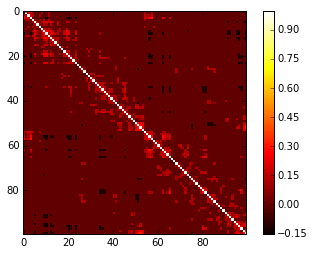

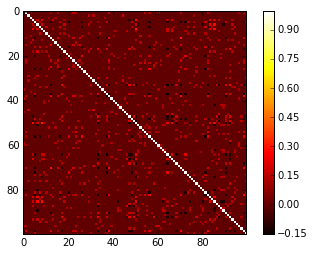

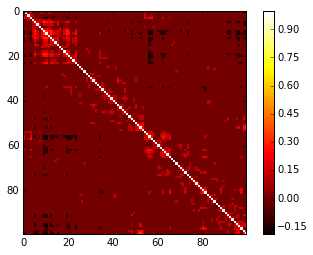

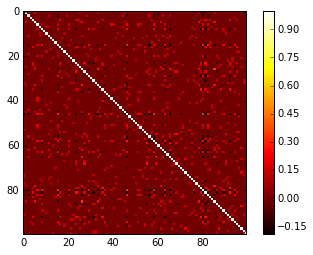

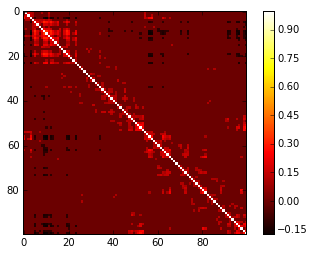

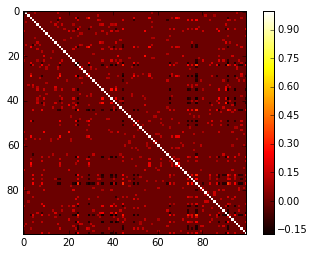

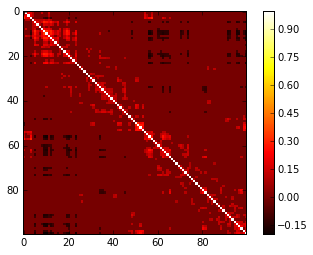

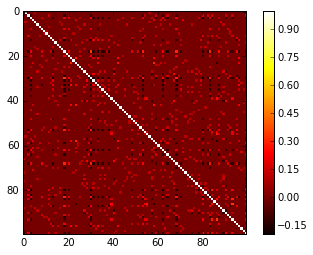

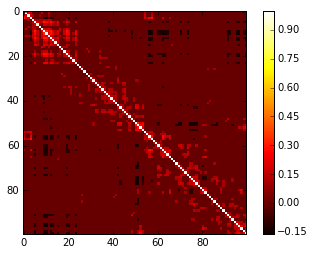

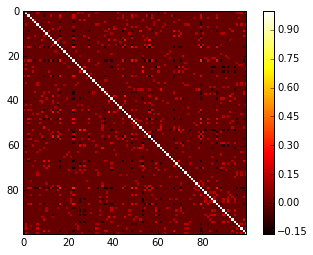

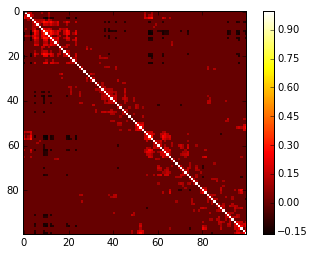

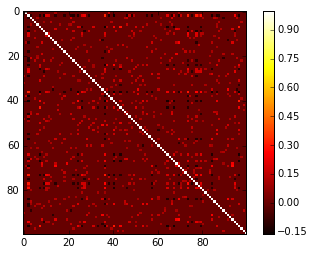

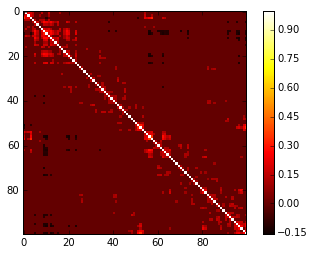

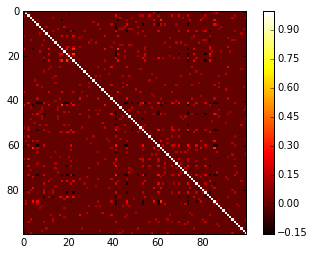

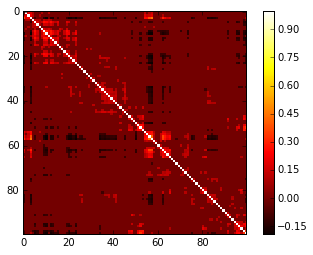

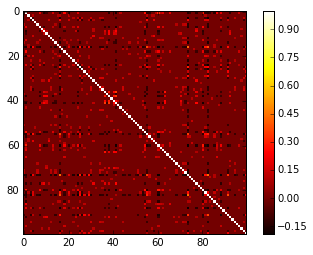

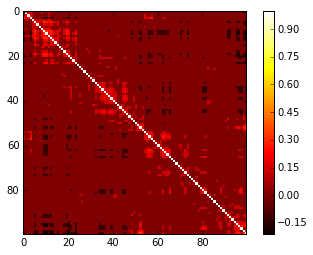

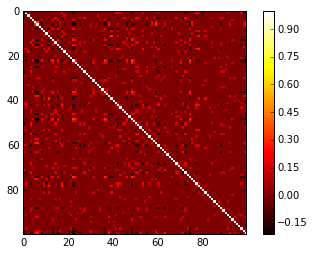

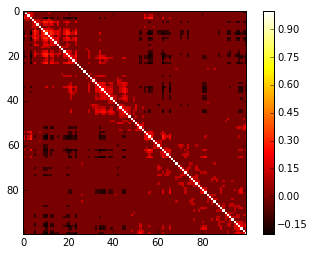

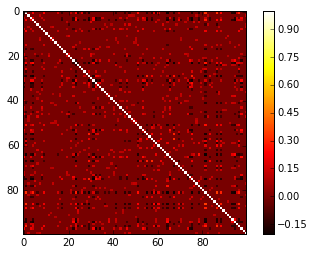

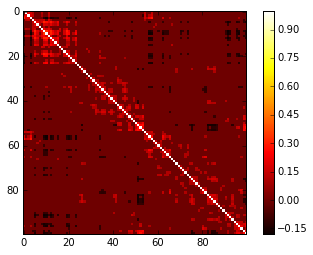

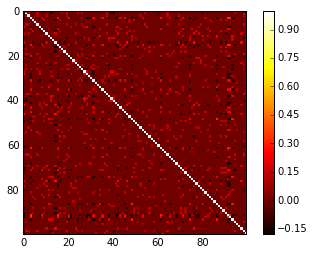

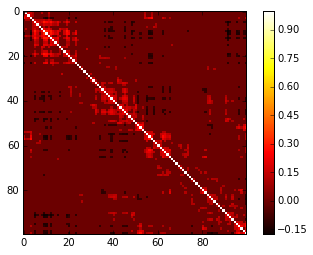

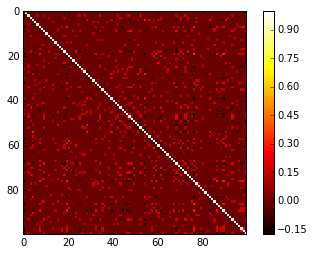

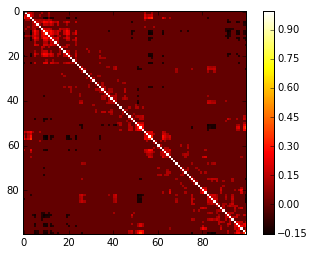

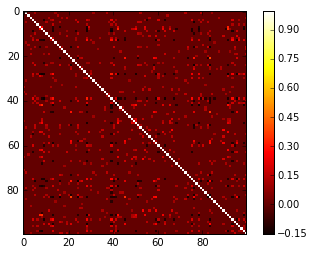

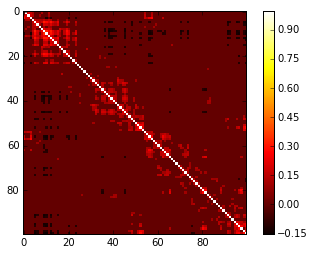

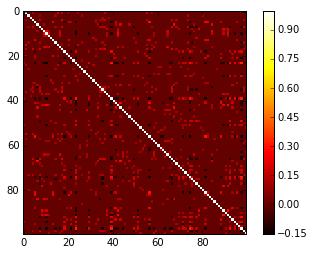

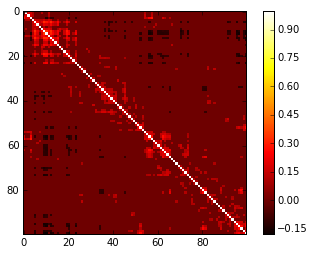

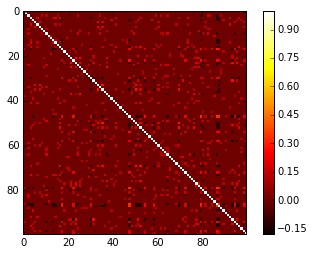

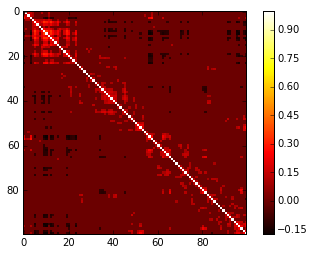

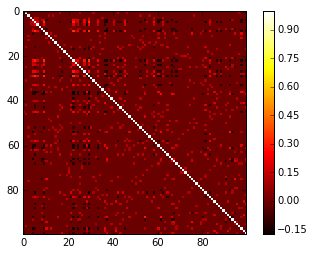

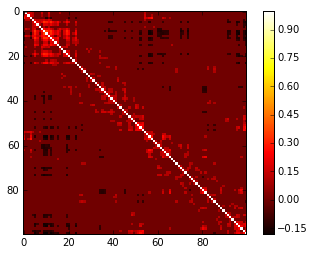

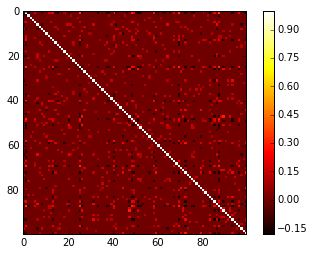

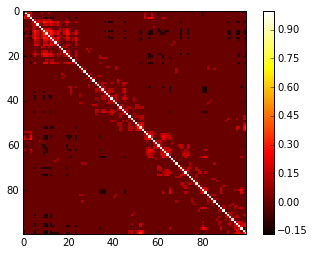

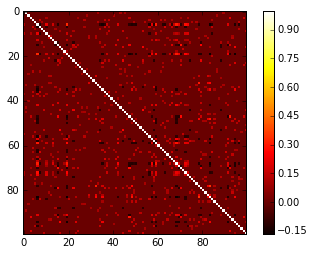

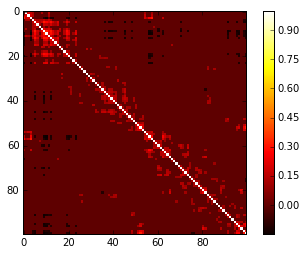

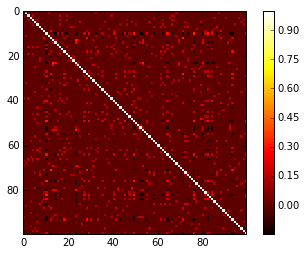

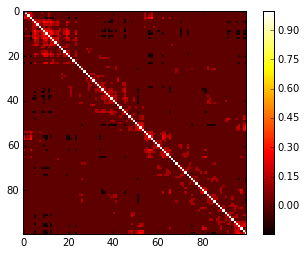

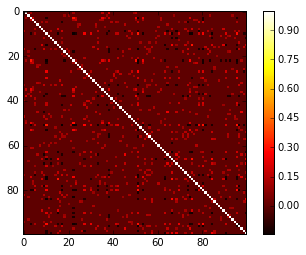

In [129]:
count = 0
for i in range(0,20):
    prac = MEG_DATAex1[1][1][0:100,count:(count+3000)]
    prac = skl.preprocessing.scale(prac)
    PRAC = prac
#     prac = prac.T
    s_cov = skl.covariance.shrunk_covariance(np.cov(PRAC),0.8)
#     model = skl.covariance.GraphLassoCV(alphas=10,n_refinements=1,cv=2, assume_centered=True) #, tol = 0.00001)
#     model.fit(prac)
#     cov_estimate = model.covariance_
#     prec_estimate = model.precision_
#     diag = np.diagonal(cov_estimate)
    diag = np.diagonal(s_cov)
    diag_inverse = np.diag(f1(diag))
#     partial_cor = diag_inverse.dot(cov_estimate).dot(1.0*diag_inverse)
    partial_cor = diag_inverse.dot(s_cov).dot(1.0*diag_inverse)
    partial_cor[abs(partial_cor) < 0.1] = 0
    plasma = plt.get_cmap('hot')
    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue','red','black'], 256)
    img = plt.imshow(partial_cor, interpolation='nearest', cmap = plasma)
    plt.colorbar(img,cmap=cmap2)
    plt.show()
    
    np.random.shuffle(prac)
    PRAC = prac
#     prac = prac.T
    s_cov = skl.covariance.shrunk_covariance(np.cov(PRAC),0.8)
#     model = skl.covariance.GraphLassoCV(alphas=10,n_refinements=1,cv=2, assume_centered=True) #, tol = 0.00001)
#     model.fit(prac)
#     cov_estimate = model.covariance_
#     prec_estimate = model.precision_
#     diag = np.diagonal(cov_estimate)
    diag = np.diagonal(s_cov)
    diag_inverse = np.diag(f1(diag))
#     partial_cor = diag_inverse.dot(cov_estimate).dot(1.0*diag_inverse)
    partial_cor = diag_inverse.dot(s_cov).dot(1.0*diag_inverse)
    partial_cor[abs(partial_cor) < 0.1] = 0
    plasma = plt.get_cmap('hot')
    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue','red','black'], 256)
    img = plt.imshow(partial_cor, interpolation='nearest', cmap = plasma)
    plt.colorbar(img,cmap=cmap2)
    plt.show()
    count = count+3000

In [80]:
count = 0
for i in range(0,12):
    prac = MEG_DATAex3[1][1][0:100,count:(count+8000)]
    prac = skl.preprocessing.scale(prac)
    PRAC = prac
    prac = prac.T
    model = skl.covariance.GraphLassoCV(alphas=10,n_refinements=1,cv=4, assume_centered=True) #, tol = 0.00001)
    model.fit(prac)
    cov_estimate = model.covariance_
    prec_estimate = model.precision_
    diag = np.diagonal(cov_estimate)
    diag_inverse = np.diag(f1(diag))
    partial_cor = diag_inverse.dot(cov_estimate).dot(1.0*diag_inverse)
    partial_cor[partial_cor < 0.1] = 0
    plasma = plt.get_cmap('hot')
    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue','red','black'], 256)
    img = plt.imshow(partial_cor, interpolation='nearest', cmap = plasma)
    plt.colorbar(img,cmap=cmap2)
    plt.show()
    count = count+8000

FloatingPointError: Non SPD result: the system is too ill-conditioned for this solver. The system is too ill-conditioned for this solver

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


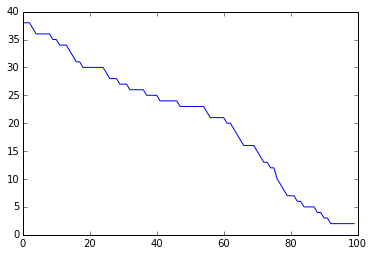

(array([ 16.,   7.,   3.,   8.,   3.,  16.,  18.,  11.,   7.,  11.]),
 array([  2. ,   5.6,   9.2,  12.8,  16.4,  20. ,  23.6,  27.2,  30.8,
         34.4,  38. ]),
 <a list of 10 Patch objects>)

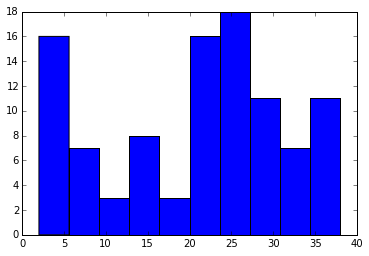

In [73]:
print type(partial_cor)
V = np.asarray(partial_cor)
print type(V)
G = nx.from_numpy_matrix(V)
G1 = nx.Graph()

# nx.info(G1)

weights = []
for i in range(len(partial_cor)):
    for j in range(len(partial_cor)):
        weights.append((i,j,partial_cor[i][j]))

# nx.draw(G,pos=nx.circular_layout(G))

# G1.add_weighted_edges_from(weights,weight ='weight')
# labels = nx.get_edge_attributes(G1,'weight')
# nx.draw(G,pos=nx.circular_layout(G))
# nx.draw_networkx_edge_labels(G,pos=nx.circular_layout(G), edge_labels=labels)

path = nx.floyd_warshall(G, weight = 'weight')
plt.plot(sorted(nx.degree(G).values(),reverse=True))
plt.show()
plt.hist(nx.degree(G).values())

### Regularization Practice using GLASSO (graphical lasso)

The graphical lasso algorithm (Friedmann et al. 2007) takes the emperical covariance, a float value for alpha (the regularization parameter) and outputs the estimate covariance and inverse covariance matrix. Increasing alpha increases the sparsity of the resulting matrix.

--------------------
Initiate Captain's Log - 21:00 - 29/08/2017:

Current blocks I need to overcome. First, the empirical covariance matrix appears to be ill-conditioned, preventing a sensible estimation using the grapical lasso. When using the full sensor network (approx 100), and parcellating the data into >=101 observations, it is not computable currently. Need to figure out whether the data covariance matrix is trully ill-conditioned, or if it is merely and error in the code. The numpy.linalg.cond(COV) returns a condition number ranging from 150->1e15, which suggests it is tending to infinity, thus being ill-conditioned. A preliminary reading of Ledoit & Wolf 2001  "A well-conditioned estimator for large dimensional covariance matrices", seems to suggest a fix to the problem. But given the paper is 16 years old, their may be others using some other regularization, but as it stands it seems my matrices will need to remain ill-posed for tonight... 

Close Captain's Log - 21:15 - 29/08/2017.

---------------------

Initiate Captain's Log - 12:00 - 30/08/2017:

The issue of the matrix data covariance matrix being ill-conditioned persists. I am trying to wrap my head around the various regularization/shrinkage methods that attempt to deal with this issue in one way or another, but this is slow going as the material is dense. One thing I feel more confident about is that the time series for the channels is stationary, which is a requirement of many of the methods. A quick simple test, from some preliminary readings is to observe how the mean and variance of the data change over larger intervals. I did a quick check and the mean and variance for each of the time series, remains quite stationary as the intervals went from 0-100, 0-1000, 0-10000 and 0-100000. Also, when plotting the time series data, it does not not appear to have any increasing or decreasing trends, purely from eyeing the data (obviously this is not very precise, but it is a okay sanity check). Furthermore, when binning each time series over increasing interval sizes, the histogram follows a gaussian form, which is again reassuring, as the foundations of all of this relies on the fact that we can assume it be be gaussian and i.i.d.

Close Captain's Log - 12:30 - 30/08/2017.

[[-1.         -0.50249911 -0.33392162 ..., -0.10883408 -0.14652493
  -0.18720864]
 [-0.50249911 -1.         -0.30609125 ..., -0.04838314 -0.06408112
  -0.08190027]
 [-0.33392162 -0.30609125 -1.         ..., -0.03046546 -0.01591113
  -0.02856041]
 ..., 
 [-0.10883408 -0.04838314 -0.03046546 ..., -1.         -0.18129337
  -0.30087453]
 [-0.14652493 -0.06408112 -0.01591113 ..., -0.18129337 -1.         -0.71905397]
 [-0.18720864 -0.08190027 -0.02856041 ..., -0.30087453 -0.71905397 -1.        ]]


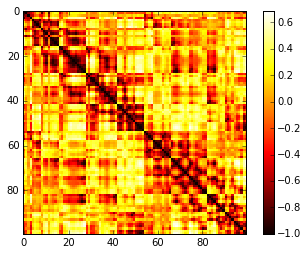

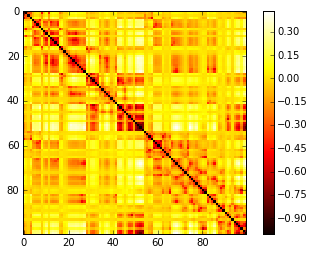

In [100]:
# print MEG_DATAex1[1][1][0]
# print MEG_DATAex3[1][1][0]

# for i in range(0,1):
#     plt.plot(MEG_DATAex1[1][1][i][range(0,100)])      
# print len(MEG_DATAex1[1][1][0])
def f1(x):
    return 1.0/math.sqrt(x)
f1 = np.vectorize(f1)
AXE = np.array(MEG_DATAex1[1][1][0:100,0:150])

# AXE = AXE*10**(12)
# AXE = skl.preprocessing.normalize(AXE)
AXE = skl.preprocessing.scale(AXE)

ECOV = np.cov(AXE)
IECOV = np.matrix(ECOV).I
diagx = np.diagonal(ECOV) 
ICx = np.diag(f1(diagx))
PCx = ICx.dot(ECOV).dot(-1.0*ICx)

# print PCx
# print
GLC = skl.covariance.graph_lasso(ECOV,0.2, max_iter = 1000)
PCGL = GLC[1]
diagz = np.diagonal(GLC[0]) 
ICz = np.diag(f1(diagz))
PCz = ICz.dot(GLC[0]).dot(-1.0*ICz)
print PCz

plasma = plt.get_cmap('hot')
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue','red','black'], 256)
img23 = plt.imshow(PCx, interpolation='nearest', cmap = plasma) #origin='lower'
plt.colorbar(img23,cmap=cmap2)
plt.show()

img2 = plt.imshow(PCz, interpolation='nearest', cmap = plasma) #origin='lower'
plt.colorbar(img2,cmap=cmap2)
plt.show()

# print np.linalg.cond(ECOV)
# print np.linalg.cond(GLC[0])
# print np.dot(ECOV,IECOV)


# x = np.array(MEG_DATAex1[1][1][0:100,0:110])
# x = x.T
# t = len(x)
# n = len(x[0])
# x = x-(np.ones((t,1))*np.mean(x,axis=0))
# sample = (1.0/(t-1))*(np.dot((x.T),x)) # Ledoit-wolf has 1/t not 1/(t-1), pretty sure they made typo. Or they are using MLE equation with "known" mean.
# var = np.diag(sample)
# sqrtvar = np.sqrt(var)
# rcor = np.corrcoef(x,rowvar=False)
# rut = np.triu(rcor,k=1)
# rBar = (2.0/((n-1.0)*n))*np.sum(rut)
# prior = rBar*((sqrtvar*np.ones((n,1))).T)*((sqrtvar*np.ones((n,1))))
# prior[np.diag_indices(len(prior))] = var
# y = np.square(x)
# phiMat = (np.dot(y.T,y)/t) - 2*(np.dot(x.T,x))*sample/t + np.square(sample)
# phi = np.sum(phiMat)
# term1 = (np.dot(np.power(x,3).T,x))/t
# helpp = np.dot(x.T,x)/t
# helpdiag = np.diag(helpp)
# term2 = (helpdiag*np.ones((n,1))).T*sample
# term3 = helpp*((var*np.ones((n,1))).T)
# term4 = (var*np.ones((n,1))).T*sample
# thetaMat = term1-term2-term3+term4
# thetaMat[np.diag_indices(len(thetaMat))] = 0
# rho = sum(np.diag(phiMat))+rBar*np.sum(np.multiply(np.dot((1/np.matrix(sqrtvar)).T,np.matrix(sqrtvar)),thetaMat))
# gamma = np.linalg.norm((sample-prior),'fro')**2
# kappa = (phi-rho)/gamma
# shrinkage = np.maximum(0,np.minimum(1,kappa/t))  
# sigma = shrinkage*prior+(1-shrinkage)*sample
# print np.linalg.cond(sample)
# print
# print np.linalg.cond(sigma)
# print
# print shrinkage

# AXE3 = np.array(MEG_DATAex3[1][1][0:10,0:1000])
# #AXE = AXE*10**(13)
# #AXE3 = skl.preprocessing.normalize(AXE3)
# ECOV3 = np.cov(AXE3)
# IECOV3 = np.matrix(ECOV3).I
# diagx3 = np.diagonal(ECOV3) 
# ICx3 = np.diag(f1(diagx3))
# PCx3 = ICx3.dot(ECOV3).dot(-1.0*ICx3)
# # plt.plot(AXE3[0:10])
# # plt.show()

# print ECOV
# print
# print IECOV
# print 
# print PCx
# print
# plt.plot(AXE[0])
# plt.plot(AXE[20])
# plt.show()

# plasma = plt.get_cmap('hot')
# cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue','red','black'], 256)
# img2 = plt.imshow(PCx, interpolation='nearest', cmap = plasma) #origin='lower'
# plt.colorbar(img2,cmap=cmap2)
# plt.show()

# plasma = plt.get_cmap('hot')
# cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue','red','black'], 256)
# img23 = plt.imshow(PCx3, interpolation='nearest', cmap = plasma) #origin='lower'
# plt.colorbar(img23,cmap=cmap2)
# plt.show()
# print ECOV
# OUT = skl.covariance.graph_lasso(ECOV, 0.001, cov_init=None, mode='lars',max_iter = 1000)#,tol = 0.0000000001, max_iter = 500)#,eps=10e-5)
# print OUT[0]
# print
#---Regularized PC network
# diag = np.diagonal(OUT[0]) 
# IC = np.diag(f1(diag))
# PC1 = IC.dot(OUT[0]).dot(-1.0*IC)
# print PC1
# plasma = plt.get_cmap('hot')
# cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue','red','black'], 256)
# img1 = plt.imshow(PC1, interpolation='nearest', cmap = plasma) #origin='lower'
# plt.colorbar(img1,cmap=cmap2)
# plt.show()
# inverse_sigma = np.matrix(sigma).I
# diagx3 = np.diagonal(sigma)
# ICx3 = np.diag(f1(diagx3))
# PCx3 = ICx3.dot(sigma).dot(-1.0*ICx3)


### 2. Channel Analysis of MEG Data - Partial Correlation Calculation and Practice Plot

#### Define channel data, compute covariance matrix for the channels, take inverse of covariance, then use the formula to compute the partial correlations; 
$P_{XY|Z} = -\frac{\rho_{ij}}{\sqrt{\rho_{ii}\rho_{jj}}}$

$corr(X) = (diag(\Sigma)^{-1/2})\Sigma(diag{\Sigma}^{-1/2})$

In [20]:
# Define multichannel array
multi_channelex1 = []
for i in range(0,10):
    multi_channelex1.append(MEG_DATAex1[1][1][i][range(0,100)])

scaled1 = [[] for x in range(len(multi_channelex1))]
for i in range(len(multi_channelex1)):
    for j in range(0,100):
        scaled1[i].append(abs(multi_channelex1[i][j]*10**13))
        
# Compute the covariance of the channel data
cov = np.cov(scaled1)
# corr = np.corrcoef(multi_channelex1)
# Turn into numpy matrix
A = np.matrix(cov)
# Invert the covariance matrix
invcov = A.I
print invcov[0]
# Take diagonal elements of matrix
diag_inv = np.diagonal(invcov)
# Define function to perfrom 1/sqrt(x) of diagonal elements
def f(x):
    return 1/math.sqrt(x)
# Vectorize function so that it can act on all numpy array elements
f = np.vectorize(f)
# change diagonal elements array into diagonal matrix
diag_inv = np.diag(f(diag_inv))
# Perform matrix multiplication to compute PC matrix
PC = diag_inv.dot(invcov).dot(-1.0*diag_inv)
print PC[0]        
# Plot of partial correlation in graph form
plasma = plt.get_cmap('hot')
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue','red','black'], 256)
img2 = plt.imshow(PC, interpolation='nearest', cmap = plasma) #origin='lower'
plt.colorbar(img2,cmap=cmap2)
plt.show()


[[ 0.76964452 -0.39399365 -0.01340491 -0.32442009 -0.13216913 -0.22826058
   0.08604581  0.07290322 -0.1716344   0.40992195]]
[[-1.          0.53235735  0.01783401  0.54183707  0.10653878  0.11397704
  -0.05385005 -0.06167786  0.23182311 -0.32227736]]


### 3. Time series segmentation, partial correlation and graph metric application example.


[[  1.82176997e-25   1.42820669e-25   1.26177012e-25   1.57505815e-25
    8.95626994e-26   5.99972874e-26   5.76925216e-26   7.79960422e-26
    1.09563787e-25   5.25796836e-26]
 [  1.42820669e-25   1.34521157e-25   9.98400343e-26   1.19148662e-25
    7.32630160e-26   5.28934569e-26   4.36545498e-26   5.91593090e-26
    1.04172397e-25   5.35904080e-26]
 [  1.26177012e-25   9.98400343e-26   1.11575275e-25   1.16938250e-25
    8.16764591e-26   5.49169094e-26   6.08756460e-26   8.02581919e-26
    7.18691129e-26   4.09855304e-26]
 [  1.57505815e-25   1.19148662e-25   1.16938250e-25   1.52873458e-25
    8.62288680e-26   5.80420156e-26   6.14012899e-26   8.13413264e-26
    8.83786276e-26   4.54432531e-26]
 [  8.95626994e-26   7.32630160e-26   8.16764591e-26   8.62288680e-26
    9.17488277e-26   7.23708888e-26   7.93452100e-26   8.80499713e-26
    6.09427558e-26   5.04335518e-26]
 [  5.99972874e-26   5.28934569e-26   5.49169094e-26   5.80420156e-26
    7.23708888e-26   7.46262537e-26   7.62505

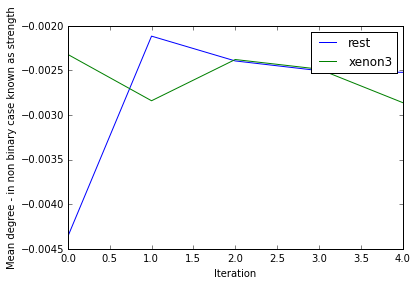

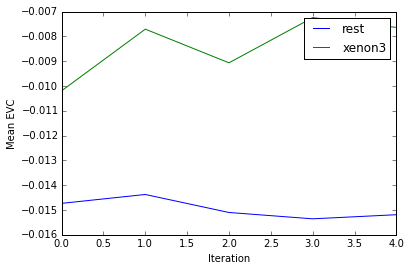

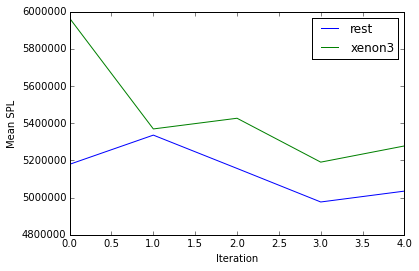

In [4]:
ITER = 5
ch_num = 10
count = 0
STRENGTH = []
STRENGTH3 = [] 
EVC = []
EVC3 = []
mean_path = []
mean_path3 = []

for x in range(ITER):
    
    multi_channelex1 = []
    for i in range(0,ch_num):
        multi_channelex1.append(MEG_DATAex1[1][1][i][range(count,(count+1)*100)])

    multi_channelex3 = []
    for i in range(0,ch_num):
        multi_channelex3.append(MEG_DATAex3[1][1][i][range(count,(count+1)*100)])
    
    cov = np.cov(multi_channelex1)
    cov3 = np.cov(multi_channelex3)
    A = np.matrix(cov)
    A3 = np.matrix(cov3)
    invcov =  A.I # Inverse matrix calculator
    invcov3 = A3.I
    print cov
    diag_inv = np.diagonal(invcov)
    def f(x):
        return 1/math.sqrt(x)
    f = np.vectorize(f)
    diag_inv = np.diag(f(diag_inv))
    PC = diag_inv.dot(invcov).dot(-1.0*diag_inv)
    
    diag_inv3 = np.diagonal(invcov3)
    def f3(x):
        return 1/math.sqrt(x)
    f3 = np.vectorize(f3)
    diag_inv3 = np.diag(f3(diag_inv3))
    PC3 = diag_inv3.dot(invcov3).dot(-1.0*diag_inv3)

    count = count + 100
    # Graph Metrics
    SUM = []
    SUM3 = []
    for e in range(len(PC)):
        SUM.append(sum(PC[e]))
    STRENGTH.append(np.mean(SUM))
    
    for b in range(len(PC3)):
        SUM3.append(sum(PC3[b]))
    STRENGTH3.append(np.mean(SUM3))
    
    X_matrix = np.ones((ch_num,1))
    for c in range(0,ITER): # Number of iterations to converge on eigenvector values X
        X_E = np.dot(PC, X_matrix) # Vector product
        normX = np.linalg.norm(X_E)
        X_matrix = X_E/normX
    EVC.append(np.mean(X_matrix))
    
    X_matrix3 = np.ones((ch_num,1))
    for c in range(0,ITER): # Number of iterations to converge on eigenvector values X
        X_E3 = np.dot(PC3, X_matrix3) # Vector product
        normX3 = np.linalg.norm(X_E3)
        X_matrix3 = X_E3/normX3
    EVC3.append(np.mean(X_matrix3))

    G1 = nx.Graph()
    weights = []
    for i in range(len(PC)):
        for j in range(len(PC)):
            weights.append((i,j,PC[i].item(j)))
    G1.add_weighted_edges_from(weights,weight ='weight')
    labels = nx.get_edge_attributes(G1,'weight')
    path = nx.floyd_warshall(G1, weight = 'weight')
    sum_path = []
    for i in range(len(path)):
        for j in range(len(path)):
            sum_path.append(abs(path[i][j]))
    #mean_path.append(np.mean(sum_path)/max(sum_path))
    mean_path.append(np.mean(sum_path))
    
    G3 = nx.Graph()
    weights3 = []
    for i in range(len(PC3)):
        for j in range(len(PC3)):
            weights3.append((i,j,PC3[i].item(j)))
    G3.add_weighted_edges_from(weights3,weight ='weight')
    labels3 = nx.get_edge_attributes(G3,'weight')
    path3 = nx.floyd_warshall(G3, weight = 'weight')
    sum_path3 = []
    for i in range(len(path3)):
        for j in range(len(path3)):
            sum_path3.append(abs(path3[i][j]))
    #mean_path3.append(np.mean(sum_path3)/max(sum_path3))
    mean_path3.append(np.mean(sum_path3))
print 'finish'

plt.xlabel('Iteration')
plt.ylabel('Mean degree - in non binary case known as strength')
plt.plot(STRENGTH, label = 'rest')
plt.plot(STRENGTH3, label = 'xenon3')
plt.legend()
plt.show()

plt.xlabel('Iteration')
plt.ylabel('Mean EVC')
plt.plot(EVC, label = 'rest')
plt.plot(EVC3, label = 'xenon3')
plt.legend()
plt.show()

plt.xlabel('Iteration')
plt.ylabel('Mean SPL')
plt.plot(mean_path, label = 'rest')
plt.plot(mean_path3, label = 'xenon3')
plt.legend()
plt.show()

# print mean_path
# print mean_path3

### 4. Graph Metrics Application

#### Eigenvector centrality

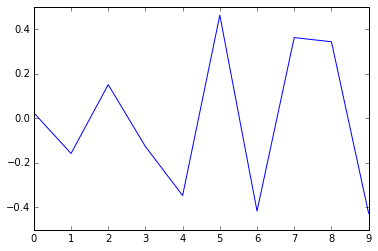

In [22]:
X_matrix = []
#X_E = []
Q = []
XX = []
normX = []
Partial = PC
N = len(PC)

for k in range(0,N):
     X_matrix.append(1)

AZ = np.dot(Partial, X_matrix)

for c in range(0,25): # Number of iterations to converge on eigenvector values X
    X_E = np.dot(Partial, X_matrix) # Vector product
    normX = np.linalg.norm(X_E)
    X_matrix = X_E/normX


plt.plot(X_matrix)
plt.show()

#### Shortest path length

<type 'list'>
<type 'numpy.ndarray'>


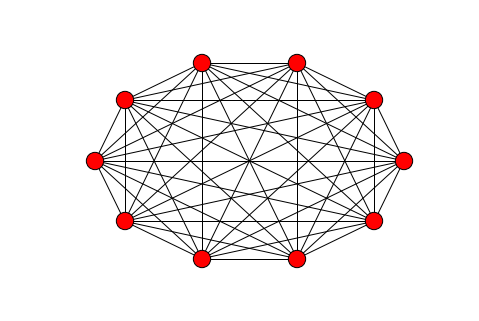

In [26]:
print type(PC)
V = np.asarray(PC)
print type(V)
G = nx.from_numpy_matrix(V)
G1 = nx.Graph()
nx.draw(G1)
nx.info(G1)
#weights = [[] for x in range(len(PC))]
weights = []

for i in range(len(PC)):
    for j in range(len(PC)):
        weights.append((i,j,PC[i][j]))

G1.add_weighted_edges_from(weights,weight ='weight')
labels = nx.get_edge_attributes(G1,'weight')
nx.draw(G1,pos=nx.circular_layout(G1))
#nx.draw_networkx_edge_labels(G1,pos=nx.circular_layout(G1), edge_labels=labels)
path = nx.floyd_warshall(G1, weight = 'weight')

sum_path = []
for i in range(len(path)):
    for j in range(len(path)):
        sum_path.append(abs(path[i][j]))
mean_path = np.mean(sum_path)



#### Clustering Coefficient

{0: 0.16365558469693361, 1: 0.1644064203819905, 2: 0.1820657685054176, 3: 0.17190658891365185, 4: 0.2469640295700769, 5: 0.26299111059468905, 6: 0.22470764867497772, 7: 0.22971508625619677, 8: 0.2689373800402823, 9: 0.2785087916820035}


0.21938584093162197

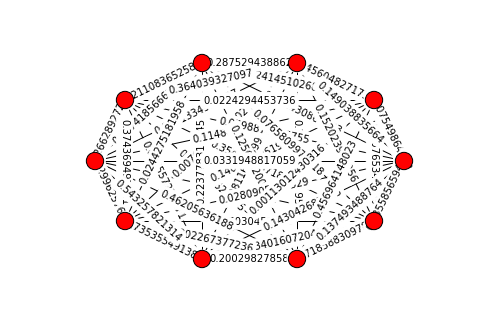

In [37]:
Gx = nx.Graph()
wei = []

for i in range(len(PC)):
    for j in range(len(PC)):
        wei.append((i,j,abs(PC[i][j])))
# Only works for positive weights. Need to code generalized negative/positive algorithm
Gx.add_weighted_edges_from(wei,weight ='weight')
labels = nx.get_edge_attributes(Gx,'weight')
nx.draw(Gx,pos=nx.circular_layout(G1))
nx.draw_networkx_edge_labels(Gx,pos=nx.circular_layout(Gx), edge_labels=labels)

print nx.clustering(Gx,weight = 'weight')
nx.average_clustering(Gx, weight = 'weight')

### Appendix: Pieces of code to be saved - Ignore all code below here


In [ ]:
signal = copy.deepcopy(MEG_DATAex1[1][1][51,0:100000])*1e12
fourier = np.fft.fft(signal)
print fourier
n = signal.size
timestep = 0.001
freq = np.fft.fftfreq(n, d=timestep)
ind = np.arange(1,n/2+1)
freq[ind]
print
freq[-ind]
psd = abs(fourier[ind])**2+abs(fourier[-ind])**2
plt.plot(freq[ind],psd)
#plt.xlim(-1,30)

In [ ]:
# Rough eigenvector centrality 
# for c in range(0,1): # Number of iterations to converge on eigenvector values X 
#     for i in range(0,N): # Multiply the elements of A with the vector X
#         B = Partial[i] # B = row 'i' of Matrix A
        
#         for j in range(len(B)): # Iterate throught the elements in B and X and multiply
#             Q.append(B[j]*X_matrix[j]) # Append to Q-count array
        
#         X_E.append(sum(Q))      # Sum the Q values, to create element 'i' of new x-vector
#         Q = []                  # Clear Q array for next iteration
#     print X_E
#     X_matrix = X_E # Set the X_matrix equal to the new X_E matrix ready for next iteration
#     X_E = []
#     normX = []
#     for x in range(len(X_matrix)):
#         normX.append(abs(X_matrix[x])/max(X_matrix))
#     X_matrix = normX

#--------------------------------------------------------------------------------------
# Compute the partial correlation
# PC = [[] for x in range(len(cov))]
# for i in range(len(invcov)):
#     for j in range(len(invcov)):
#         PC[i].append(-1.0*(invcov.item(i,j)/math.sqrt(invcov.item(i,i)*invcov.item(j,j))))

In [137]:
loop_set = master_set[0:100,0:2000]
loop_set = skl.preprocessing.scale(loop_set)
# EMP_COV = np.cov(loop_set)
# E1 = skl.covariance.shrunk_covariance(EMP_COV,0.01)
# E2 = skl.covariance.empirical_covariance(loop_set)

gl_model = skl.covariance.GraphLassoCV(alphas=10, n_refinements=2, cv=10, assume_centered=True, max_iter=100)#,  mode='lars', tol = 0.00000001)
gl_model.fit(loop_set.T)
gl_cov = gl_model.covariance_


# print np.linalg.cond(EMP_COV)
# print np.linalg.cond(E1)
# print np.linalg.cond(E2)
# print np.linalg.cond(skl.covariance.shrunk_covariance(EMP_COV,0.1))
print np.linalg.cond(gl_cov)

FloatingPointError: Non SPD result: the system is too ill-conditioned for this solver. The system is too ill-conditioned for this solver

In [ ]:
def f1(x):
    return 1.0/math.sqrt(x)
f1 = np.vectorize(f1)
master_set = copy.deepcopy(MEG_DATAex1[1][1][0:5,0:100])*1e12
graphs = [[]for i in range(0,10000)]
print 'done'




for i in range(0,1):
    count = 0
    #print'iteration '+ str(i)
    for j in range(0,5):
        loop_s = [[] for k in range(0,5)]
        for y in range(0,5):    
            z = rn.randint(0,90)
            loop_s[y] = master_set[y][z:(z+10)]
            #print loop_s
        loop_s = skl.preprocessing.scale(loop_s)
        print "do graph stuff"
        oas_ = skl.covariance.oas(loop_s.T,assume_centered=True)
        oas_cov = oas_[0]
        diag = np.diagonal(oas_cov)
        diag_inverse = np.diag(f1(diag))
        partial_cor = diag_inverse.dot(oas_cov).dot(1.0*diag_inverse)
        partial_cor[abs(partial_cor) < 0.8] = 0
        partial_cor[abs(partial_cor) > 0] = 1
        adjacency = partial_cor
        np.fill_diagonal(adjacency,0)
trial = []

# loop_set = master_set[0:100,0:2000]
# loop_set = skl.preprocessing.scale(loop_set)
# EMP_COV = np.cov(loop_set)


# gl_model = skl.covariance.GraphLassoCV(alphas=10, n_refinements=2, cv=10, assume_centered=True, max_iter=100)#,  mode='lars', tol = 0.00000001)
# gl_model.fit(loop_set.T)
# gl_cov = gl_model.covariance_


# print np.linalg.cond(EMP_COV)
# print np.linalg.cond(skl.covariance.shrunk_covariance(EMP_COV,0.1))
# print np.linalg.cond(gl_cov)

# diag = np.diagonal(gl_model.covariance_)
# diag_inverse = np.diag(f1(diag))
# partial_cor = diag_inverse.dot(gl_model.covariance_).dot(1.0*diag_inverse)
# print partial_cor[0]
# print
# partial_cor[abs(partial_cor) < 0.1] = 0
# partial_cor[abs(partial_cor) > 0] = 1
# adjacency = partial_cor
# np.fill_diagonal(adjacency,0)
# G = nx.Graph(adjacency)
# trial.append(nx.degree(G).values())



# oas_cov = skl.covariance.oas(loop_set.T,assume_centered=True)
# oas_cov = oas_[0]
# diag = np.diagonal(oas_cov)
# diag_inverse = np.diag(f1(diag))
# partial_cor = diag_inverse.dot(oas_cov).dot(1.0*diag_inverse)
# print partial_cor[0]
# print
# partial_cor[abs(partial_cor) < 0.1] = 0
# partial_cor[abs(partial_cor) > 0] = 1
# adjacency = partial_cor
# np.fill_diagonal(adjacency,0)
# G = nx.Graph(adjacency)
# trial.append(nx.degree(G).values())



# lw_model = skl.covariance.LedoitWolf()
# lw_model.fit(loop_set.T)
# lw_cov = lw_model.covariance_
# diag = np.diagonal(lw_cov)
# diag_inverse = np.diag(f1(diag))
# partial_cor = diag_inverse.dot(lw_cov).dot(1.0*diag_inverse)
# print partial_cor[0]
# print
# partial_cor[abs(partial_cor) < 0.1] = 0
# partial_cor[abs(partial_cor) > 0] = 1
# adjacency = partial_cor
# np.fill_diagonal(adjacency,0)
# G = nx.Graph(adjacency)
# trial.append(nx.degree(G).values())

# print trial[0]
# print
# print trial[1]
# print 
# print trial[2]


test_set = copy.deepcopy(MEG_DATAex1[1][1][0:3,0:20])*1e12
print test_set[0]
print
print test_set[1]
small_set = [[] for i in range(0,3)]
for i in range(0,3):
    xx = rn.randint(0,15)
    small_set[i] = test_set[i][xx:xx+5] 
print 
print small_set[0]
print 
print small_set[1]

In [ ]:
for j in range(0,25):
    loop_set = master_set[0:100,count:(count+step)]
    #gl_model = skl.covariance.GraphLasso(alpha = 0.05, assume_centered=False, tol = 0.01)
    gl_model = skl.covariance.GraphLassoCV(alphas=10, n_refinements=1, cv=5, assume_centered=False, max_iter=100, tol = 0.001)
    gl_model.fit(loop_set.T)
#     loop_set = skl.preprocessing.scale(loop_set)
#     oas_ = skl.covariance.oas(loop_set.T,assume_centered=False)
#     oas_cov = oas_[0]
    diag = np.diagonal(gl_model.covariance_)
    diag_inverse = np.diag(f1(diag))
    partial_cor = diag_inverse.dot(gl_model.covariance_).dot(1.0*diag_inverse)
#     diag = np.diagonal(gl_model.covariance_)
#     diag_inverse = np.diag(f1(diag))
#     partial_cor = diag_inverse.dot(gl_model.covariance_).dot(1.0*diag_inverse)
#     partial_cor[abs(partial_cor) < 0.5] = 0
#     partial_cor[abs(partial_cor) > 0] = 1
#     adjacency = partial_cor
#     np.fill_diagonal(adjacency,0)
    #graphs[it] = nx.Graph(partial_cor)
    #print gl_model.alpha_
    PCN[it] = partial_cor
    graphs[it] = nx.Graph(partial_cor)
    it = it+1
    count = count+4000
print 'finished'


for i in range(0,5):
    #if i % 100 == 0:
    print'iteration '+ str(i)
    for j in range(0,25):
        loop_s = [[] for k in range(0,100)]
        for y in range(0,100):    
            z = rn.randint(0,96000)
            loop_s[y] = master_set[y][z:(z+4000)]
        #loop_s = skl.preprocessing.scale(loop_s)
        #gl_model = skl.covariance.GraphLasso(alpha = 0.05, assume_centered=False, tol = 0.01)
        gl_model = skl.covariance.GraphLassoCV(alphas=10, n_refinements=1, cv=5, assume_centered=False, max_iter=100, tol = 0.001)
        gl_model.fit(np.array(loop_s).T)
#         oas_ = skl.covariance.oas(np.array(loop_s).T,assume_centered=False)
#         oas_cov = oas_[0]
        diag = np.diagonal(gl_model.covariance_)
        diag_inverse = np.diag(f1(diag))
        partial_cor = diag_inverse.dot(gl_model.covariance_).dot(1.0*diag_inverse)
#         partial_cor[abs(partial_cor) < 0.5] = 0
#         partial_cor[abs(partial_cor) > 0] = 1
#         adjacency = partial_cor
#         np.fill_diagonal(adjacency,0)
        PCN[it] = partial_cor
        graphs[it] = nx.Graph(partial_cor)
        it = it+1

print 'finished'


